# Analysis of flight cancellations and delays data

## About the database

Dataset of flight cancellations and delays for US airlines in January 2023, extracted from the US Department of Transportation, Bureau of Transportation Statistics (https://www.transstats.bts.gov) and available on Kaggle.

Variables include flight routes (origin and destination), time intervals between events (minutes, time at destination), reasons/attributions for delays and cancellations.

## Variable description

### DOT_CODE_DICTIONARY table

| Variable | Description |
| -------- | --------- |
| Code | Numeric identifier from the U.S. Department of Transportation (DOT) for airlines |
| Description | Airline description |

### AIRLINE_CODE_DICTIONARY table

| Variable | Description |
| -------- | --------- |
| Code | Unique operator code for aircraft operator agencies |
| Description | Description of the aircraft operator agency |

### flights_202301 table

| Variable | Description |
| -------- | --------- |
| FL_DATE | Flight date (yyyymmdd) |
| AIRLINE_CODE | Unique operator code. When multiple operators use the same code, a numeric suffix is used to differentiate previous users, e.g., PA, PA(1), PA(2). |
| DOT_CODE | Identification number assigned by the US DOT to identify a unique airline (carrier). A unique airline (carrier) is defined as one that owns and reports under the same DOT certificate regardless of its code, name, or holding/company. |
| FL_NUMBER | Flight number |
| ORIGIN | Origin airport |
| ORIGIN_CITY | Origin airport, city name |
| DEST | Destination airport |
| DEST_CITY | Destination airport, city name |
| CRSDEPTIME | Scheduled departure time recorded in CRS (Computer Reservation System) (local time: hhmm) |
| DEP_TIME | Actual departure time (local time: hhmm) |
| DEP_DELAY | Difference in minutes between scheduled and actual departure time. Early departures show negative numbers. |
| TAXI_OUT | Taxi out time in minutes (taxi is the process of moving an airplane while it is on the runway) |
| WHEELS_OFF | Exact takeoff time (local time: hhmm) |
| WHEELS_ON | Exact landing time (local time: hhmm) |
| TAXI_IN | Taxi in time in minutes |
| CRSARRTIME | Scheduled arrival time recorded in CRS (local time: hhmm) |
| ARR_TIME | Actual arrival time (local time: hhmm) |
| ARR_DELAY | Difference in minutes between scheduled and actual arrival time. Early arrivals show negative numbers. |
| CANCELLED | Flight cancelled indicator (1=Yes) |
| CANCELLATION_CODE | Specifies the reason for cancellation |
| DIVERTED | Flight diverted indicator (1=Yes) |
| CRSELAPSEDTIME | Total elapsed flight time in minutes recorded in CRS |
| ELAPSED_TIME | Total actual elapsed flight time in minutes |
| AIR_TIME | Air time in minutes |
| DISTANCE | Distance between airports (miles) |
| DELAYDUECARRIER | Carrier delay in minutes |
| DELAYDUEWEATHER | Weather delay in minutes |
| DELAYDUENAS | National Air System delay in minutes |
| DELAYDUESECURITY | Security delay in minutes |
| DELAYDUELATE_AIRCRAFT | Late aircraft delay in minutes |

### airports locations table

| Variable | Description |
| -------- | --------- |
| iata | Airports code |
| name | Airports name |
| city | Airports city |
| state | Airports state |
| country | Airports country |
| latitude | Airports latitude |
| longitude | Airports longitude |

## 1. Imports and data

In [121]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, ttest_ind, f_oneway, chi2_contingency

In [122]:
df_dot_code = pd.read_excel("../dataset/DOT_CODE_DICTIONARY.xlsx")
df_airline_code = pd.read_csv("../dataset/AIRLINE_CODE_DICTIONARY.csv")
df_flights = pd.read_csv("../dataset/flights_202301.csv")
airports_location = pd.read_csv("../dataset/airports.csv")

In [123]:
df_flights.drop(['FL_MONTH', 'FL_YEAR'], axis=1, inplace=True)

In [124]:
airports_location = airports_location.drop(columns=['name', 'city', 'state', 'country'])

## 2. Data treatment

### a. Renaming columns to create a pattern

In [125]:
df_dot_code = df_dot_code.rename(
    columns=lambda col: f"DOT_{col}" if col != "Code" else col
)
df_airline_code = df_airline_code.rename(
    columns=lambda col: f"AIRLINE_{col}" if col != "Code" else col
)

### b. Checking initial information and dimensions

In [126]:
print(f"Shape of df_flights: {df_flights.shape}")
print(f"Shape of df_dot_code: {df_dot_code.shape}")
print(f"Shape of df_airline_code: {df_airline_code.shape}")

Shape of df_flights: (538837, 31)
Shape of df_dot_code: (1737, 2)
Shape of df_airline_code: (1729, 2)


### c. Optimizing data types for df_flights

In [127]:
df_flights_optimized = df_flights.copy()

In [128]:
# 1. DATE CONVERSION
df_flights_optimized["FL_DATE"] = pd.to_datetime(df_flights_optimized["FL_DATE"].astype(str), format="%Y-%m-%d", errors='coerce')
df_flights_optimized["FL_DAY"] = df_flights_optimized["FL_DATE"] .dt.day.astype('float32')

In [129]:
# 2. CATEGORICAL COLUMNS
cols_category = [
    "AIRLINE_CODE", "ORIGIN", "ORIGIN_CITY", "DEST", "DEST_CITY", "CANCELLATION_CODE"
]
for col in cols_category:
    df_flights_optimized[col] = df_flights_optimized[col].astype("category")

In [130]:
# 3. BOOLEAN VARIABLES
df_flights_optimized["CANCELLED"] = df_flights_optimized["CANCELLED"].astype(bool)
df_flights_optimized["DIVERTED"] = df_flights_optimized["DIVERTED"].astype(bool)

In [131]:
# 4. FUNCTION FOR TIME CONVERSION
time_cols = ["DEP_TIME", "ARR_TIME", "CRS_DEP_TIME", "CRS_ARR_TIME", "AIR_TIME"]
for col in time_cols:
    df_flights_optimized[col] = pd.to_numeric(df_flights_optimized[col], errors="coerce")

In [132]:
num_cols = ["TAXI_IN", "TAXI_OUT", "ELAPSED_TIME", "DEP_DELAY", "ARR_DELAY"]
for col in num_cols:
    df_flights_optimized[col] = pd.to_numeric(df_flights_optimized[col], errors="coerce")

In [133]:
# 5. NUMERIC TYPE OPTIMIZATION

int_columns_small = ["FL_NUMBER", "DOT_CODE"]
for col in int_columns_small:
    if col in df_flights_optimized.columns:
        max_val = df_flights_optimized[col].max()
        if max_val <= 32767:
            df_flights_optimized[col] = df_flights_optimized[col].astype("int16")
        elif max_val <= 2147483647:
            df_flights_optimized[col] = df_flights_optimized[col].astype("int32")

if "DISTANCE" in df_flights_optimized.columns:
    df_flights_optimized["DISTANCE"] = df_flights_optimized["DISTANCE"].astype("int16")

float_columns = [
    "DEP_DELAY", "TAXI_OUT", "TAXI_IN", "ARR_DELAY",
    "CRS_ELAPSED_TIME", "ELAPSED_TIME", "AIR_TIME",
    "DELAY_DUE_CARRIER", "DELAY_DUE_WEATHER", "DELAY_DUE_NAS",
    "DELAY_DUE_SECURITY", "DELAY_DUE_LATE_AIRCRAFT"
]
for col in float_columns:
    df_flights_optimized[col] = pd.to_numeric(df_flights_optimized[col], errors='coerce')
    df_flights_optimized[col] = df_flights_optimized[col].astype("float32")

### d. Optimizing data types for df_airline_code

In [134]:
df_airline_optimized = df_airline_code.copy()

In [135]:
# 1. Convert 'Code' to category
df_airline_optimized['Code'] = df_airline_optimized['Code'].astype('category')

# 2. Convert 'AIRLINE_Description' to category
df_airline_optimized['AIRLINE_Description'] = df_airline_optimized['AIRLINE_Description'].astype('category')

### e. Optimizing data types for df_dot_code

In [136]:
df_dot_optimized = df_dot_code.copy()

In [137]:
# 1. Convert Code to numeric type
df_dot_optimized['Code'] = pd.to_numeric(df_dot_optimized['Code'], errors='coerce')
max_dot_code = df_dot_optimized['Code'].max()
if max_dot_code <= 32767:
    df_dot_optimized['Code'] = df_dot_optimized['Code'].astype('int16')
elif max_dot_code <= 2147483647:
    df_dot_optimized['Code'] = df_dot_optimized['Code'].astype('int32')

# 2. Convert 'DOT_Description' to category
df_dot_optimized['DOT_Description'] = df_dot_optimized['DOT_Description'].astype('category')
df_dot_optimized["DOT_Description"] = df_dot_optimized["DOT_Description"].str.split(":").str[0].str.strip()

### f. Comparing optimized sizes

In [138]:
def compare_memory_usage(df_name, df_original, df_optimized):
    mem_original = df_original.memory_usage(deep=True).sum() / 1024**2
    mem_optimized = df_optimized.memory_usage(deep=True).sum() / 1024**2

    print(f"Memory improvement analysis for **{df_name}**")
    print(f"{mem_original:.2f} MB → {mem_optimized:.2f} MB")
    print(f"Savings: {mem_original - mem_optimized:.2f} MB ({((mem_original - mem_optimized) / mem_original * 100):.1f}%)\n")

compare_memory_usage("df_flights", df_flights, df_flights_optimized)
compare_memory_usage("df_airline_code", df_airline_code, df_airline_optimized)
compare_memory_usage("df_dot_code", df_dot_code, df_dot_optimized)

Memory improvement analysis for **df_flights**
298.05 MB → 64.86 MB
Savings: 233.20 MB (78.2%)

Memory improvement analysis for **df_airline_code**
0.20 MB → 0.33 MB
Savings: -0.13 MB (-66.2%)

Memory improvement analysis for **df_dot_code**
0.14 MB → 0.12 MB
Savings: 0.02 MB (13.3%)



### g. Merging data

Main: df_flights

df_airline_code: Code <> df_flights: AIRLINE_CODE

df_dot_code: Code <> df_flights: DOT_CODE

In [139]:
df_merged = pd.merge(
    df_flights_optimized,
    df_dot_optimized,
    left_on="DOT_CODE",
    right_on="Code",
    how="left"
).drop(columns=["Code"])

df = pd.merge(
    df_merged,
    df_airline_optimized,
    left_on="AIRLINE_CODE",
    right_on="Code",
    how="left"
).drop(columns=["Code"])

### h. Checking and treating nulls values

In [140]:
def checkMissing(data,perc=0):
    missing = [(i, data[i].isna().mean()*100) for i in data]
    missing = pd.DataFrame(missing, columns=["column_name", "percentage"])
    missing = missing[missing.percentage > perc]
    print(missing.sort_values("percentage", ascending=False).reset_index(drop=True))

print("Proportion of missing data in columns")
checkMissing(df)

Proportion of missing data in columns
                column_name  percentage
0         DELAY_DUE_WEATHER   78.339832
1             DELAY_DUE_NAS   78.339832
2        DELAY_DUE_SECURITY   78.339832
3   DELAY_DUE_LATE_AIRCRAFT   78.339832
4         DELAY_DUE_CARRIER   78.339832
5                 ARR_DELAY    2.160208
6              ELAPSED_TIME    2.160208
7                  AIR_TIME    2.160208
8                   TAXI_IN    1.952167
9                 WHEELS_ON    1.952167
10                 ARR_TIME    1.952167
11                 TAXI_OUT    1.892409
12               WHEELS_OFF    1.892409
13                DEP_DELAY    1.852508
14                 DEP_TIME    1.851766
15         CRS_ELAPSED_TIME    0.000186


In [141]:
# Removing null in CRS_ELAPSED_TIME (1 value)
df = df.dropna(subset=["CRS_ELAPSED_TIME"])

In [142]:
# Checkin about the DELAYS in CANCELLED and DIVERTED
delay_cols = ["DELAY_DUE_CARRIER", "DELAY_DUE_WEATHER", "DELAY_DUE_NAS", "DELAY_DUE_SECURITY", "DELAY_DUE_LATE_AIRCRAFT"]

df_null_delays = df[df[delay_cols].isna().any(axis=1)]

delay_flag_0 = df_null_delays[(df_null_delays["CANCELLED"] == 0) & (df_null_delays["DIVERTED"] == 0)]
delay_flag_1 = df_null_delays[(df_null_delays["CANCELLED"] == 1) | (df_null_delays["DIVERTED"] == 1)]

total_rows = len(df)
prop_delay_flag_0 = len(delay_flag_0) / total_rows * 100
prop_delay_flag_1 = len(delay_flag_1) / total_rows * 100

print(f"Null variables on normal flight: {len(delay_flag_0):,} ({prop_delay_flag_0:.2f}%)")
print(f"Null variables on canceled/diverted flight: {len(delay_flag_1):,} ({prop_delay_flag_1:.2f}%)")

dist = delay_flag_1[["CANCELLED", "DIVERTED"]].value_counts()
dist_prop = dist / total_rows * 100

print(pd.concat([dist, dist_prop.rename("proportion %")], axis=1))

all_delay_null = delay_flag_1[delay_flag_1[delay_cols].isna().all(axis=1)]

print(f"\nCancelled/diverted lines with ALL 5 delays zero: {len(all_delay_null):,}")

Null variables on normal flight: 410,484 (76.18%)
Null variables on canceled/diverted flight: 11,639 (2.16%)
                    count  proportion %
CANCELLED DIVERTED                     
True      False     10294      1.910414
False     True       1345      0.249612

Cancelled/diverted lines with ALL 5 delays zero: 11,639


In [143]:
df.loc[df['CANCELLED'] == 0, delay_cols] = df.loc[df['CANCELLED'] == 0, delay_cols].fillna(0)

In [144]:
print("Proportion of missing data in columns")
checkMissing(df)

Proportion of missing data in columns
                column_name  percentage
0                  AIR_TIME    2.160026
1              ELAPSED_TIME    2.160026
2                 ARR_DELAY    2.160026
3                   TAXI_IN    1.951985
4                  ARR_TIME    1.951985
5                 WHEELS_ON    1.951985
6         DELAY_DUE_CARRIER    1.910414
7         DELAY_DUE_WEATHER    1.910414
8             DELAY_DUE_NAS    1.910414
9        DELAY_DUE_SECURITY    1.910414
10  DELAY_DUE_LATE_AIRCRAFT    1.910414
11               WHEELS_OFF    1.892227
12                 TAXI_OUT    1.892227
13                DEP_DELAY    1.852326
14                 DEP_TIME    1.851584


### i. Checking duplicated values

In [145]:
df.duplicated().any()

np.False_

### j. Checking out-of-scope variable data 

In [146]:
# 1. Dates out-of-scope: 2023, january
print(df["FL_DATE"].min(), "→", df["FL_DATE"].max())

2023-01-01 00:00:00 → 2023-01-31 00:00:00


In [147]:
# 2. Checking expected ranges

check_ranges = {
    "FL_DAY": (1, 31),
    "DEP_TIME": (0, 2359),
    "ARR_TIME": (0, 2359),
    "CRS_DEP_TIME": (0, 2359),
    "CRS_ARR_TIME": (0, 2359),
    "TAXI_IN": (0, None),
    "TAXI_OUT": (0, None),
    "ELAPSED_TIME": (0, None),
    "AIR_TIME": (0, None),
    "DEP_DELAY": (None, None),
    "ARR_DELAY": (None, None),
}

for col, (low, high) in check_ranges.items():
    if col in df.columns:
        if low is not None:
            invalid_low = df[df[col] < low]
            if not invalid_low.empty:
                print(f"{col}: {len(invalid_low)} values below of {low}")
        if high is not None:
            invalid_high = df[df[col] > high]
            if not invalid_high.empty:
                print(f"{col}: {len(invalid_high)} values above of {high}")

DEP_TIME: 48 values above of 2359
ARR_TIME: 281 values above of 2359


In [148]:
invalid_dep_time_vals = df.loc[df["DEP_TIME"] > 2359, "DEP_TIME"].unique()
print("DEP_TIME unique invalids:", invalid_dep_time_vals)

invalid_arr_time_vals = df.loc[df["ARR_TIME"] > 2359, "ARR_TIME"].unique()
print("ARR_TIME unique invalids:", invalid_arr_time_vals)

DEP_TIME unique invalids: [2400.]
ARR_TIME unique invalids: [2400.]


In [149]:
for col in time_cols:
    if col in df.columns:
        df.loc[df[col] == 2400, col] = 0

### k. Checking the categorical data

In [150]:
# 1. List information about categorical data
categorial_columns = df.select_dtypes(include=['object', 'category']).columns

for col in categorial_columns:
    unique_values = df[col].nunique()

    print(f"📊 {col}")
    print(f"Total unique categories: {unique_values}")

    max_list_size = 10
    if unique_values <= max_list_size:
        category_list = df[col].unique().tolist()
        print(f"Categories: {category_list}\n")
    else:
        print(f"Categories not displayed (total > {max_list_size})\n")

📊 AIRLINE_CODE
Total unique categories: 15
Categories not displayed (total > 10)

📊 ORIGIN
Total unique categories: 339
Categories not displayed (total > 10)

📊 ORIGIN_CITY
Total unique categories: 333
Categories not displayed (total > 10)

📊 DEST
Total unique categories: 339
Categories not displayed (total > 10)

📊 DEST_CITY
Total unique categories: 333
Categories not displayed (total > 10)

📊 CANCELLATION_CODE
Total unique categories: 5
Categories: ['Z', 'C', 'B', 'D', 'A']

📊 DOT_Description
Total unique categories: 15
Categories not displayed (total > 10)

📊 AIRLINE_Description
Total unique categories: 15
Categories not displayed (total > 10)



In [151]:
# 2. Create pattern
df[categorial_columns] = df[categorial_columns].apply(
    lambda col: col.astype(str)
                    .str.strip()
                    .str.upper()
                    .replace(['NA', 'N/A', 'NONE', 'NULL', '?', 'UNKNOWN'], np.nan)
)

if 'DOT_Description' in df.columns:
    df['DOT_Description'] = df['DOT_Description'].str.strip()

In [152]:
# 3. Checking similarity in DOT_Description and AIRLINE_Description - lines are the same?
similar_category = set(df['DOT_Description'].dropna().unique()) == set(df['AIRLINE_Description'].dropna().unique())
print("Do the columns have the same unique values?", similar_category)

Do the columns have the same unique values? True


In [153]:
# Removing DOT_DESCRIPTION
df = df.drop('DOT_Description', axis=1)

In [154]:
# 4. Checking inconsistent values
categorial_columns = df.select_dtypes(include=['object', 'category']).columns
for col in categorial_columns:
    print(f"{col}: {df[col].isin(['NA','?','None','UNKNOWN']).sum()} suspicious values")

AIRLINE_CODE: 0 suspicious values
ORIGIN: 0 suspicious values
ORIGIN_CITY: 0 suspicious values
DEST: 0 suspicious values
DEST_CITY: 0 suspicious values
CANCELLATION_CODE: 0 suspicious values
AIRLINE_Description: 0 suspicious values


### l. Checking the numerical data

In [155]:
numeric_columns = df.select_dtypes(include='number').columns.tolist()

def detect_outliers_iqr(series):
    Q1, Q3 = series.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return series[(series < lower) | (series > upper)]

def detect_outliers_zscore(series, threshold=3):
    z_scores = zscore(series.dropna())
    return series.iloc[(abs(z_scores) > threshold).nonzero()[0]]

results = {
    'Variable': [],
    'Outliers (IQR)': [],
    'Outliers (Z-Score)': []
}

for col in numeric_columns:
    if col in df_merged.columns:
        outliers_iqr_count = len(detect_outliers_iqr(df_merged[col]))
        outliers_zscore_count = len(detect_outliers_zscore(df_merged[col]))
        
        results['Variable'].append(col)
        results['Outliers (IQR)'].append(outliers_iqr_count)
        results['Outliers (Z-Score)'].append(outliers_zscore_count)

outliers_df = pd.DataFrame(results)
outliers_df

,Variable,Outliers (IQR),Outliers (Z-Score)
0,DOT_CODE,0,0
1,FL_NUMBER,131,67
2,CRS_DEP_TIME,0,0
3,DEP_TIME,0,0
4,DEP_DELAY,65189,7656
5,TAXI_OUT,35661,9732
6,WHEELS_OFF,0,0
7,WHEELS_ON,0,0
8,TAXI_IN,36666,10083
9,CRS_ARR_TIME,0,0


### m. Creating new variable

In [156]:
# Delays metrics

df['DELAY_TOTAL'] = df['DELAY_DUE_CARRIER'] + df['DELAY_DUE_WEATHER'] + df['DELAY_DUE_NAS'] + df['DELAY_DUE_SECURITY'] + df['DELAY_DUE_LATE_AIRCRAFT']
df['DELAY_TOTAL'] = df['DELAY_TOTAL'].astype(np.float64)

df['DELAY_OVERALL'] = df['ARR_DELAY'].apply(lambda x: x if x > 0 else 0)
df['DELAY_OVERALL'] = df['DELAY_OVERALL'].astype(np.int64)

df['DELAY'] = df['DELAY_OVERALL'].apply(lambda x: 1 if x > 0 else 0)
df['DELAY'] = df['DELAY'].astype(bool)

In [157]:
# Categorization by time of day
# df['TIME_PERIOD'] = pd.cut(df['DEP_TIME'], bins=[0, 600, 1200, 1800, 2400], 
#                           labels=['Early Morning','Morning','Afternoon','Evening'], right=False)

In [158]:
df['TIME_PERIOD'] = pd.cut(df['DEP_TIME'], bins=[0, 600, 1200, 1800, 2400], 
                           labels=["Madrugada", "Manhã", "Tarde", "Noite"], right=False)

In [159]:
df["DAY_OF_WEEK"] = df["FL_DATE"].dt.day_name('pt_BR')

weekday_order = ["Segunda-feira", "Terça-feira", "Quarta-feira", "Quinta-feira", "Sexta-feira", "Sábado", "Domingo"]

df["DAY_OF_WEEK"] = pd.Categorical(
    df["DAY_OF_WEEK"],
    categories=weekday_order,
    ordered=True
)

In [160]:
df['ORIGIN_STATE'] = df['ORIGIN_CITY'].str.split(', ').str[-1]

In [161]:
problematic_columns = ['DELAY', 'CANCELLED', 'DIVERTED']

## 3. Exploratory Data Analysis (EDA)

### a. Categorial information: merging and displaying 

In [162]:
# Count of delayed, cancelled and diverted flights
results = {
    "Variable": [],
    "Sum of occurrences": [],
    "Percentage of total (%)": []
}
total_flights = len(df)

for col in problematic_columns:
    col_sum = df[col].sum()
    col_percentage = (col_sum / total_flights) * 100
    results["Variable"].append(col)
    results["Sum of occurrences"].append(col_sum)
    results["Percentage of total (%)"].append(f"{col_percentage:.2f}")

summary_df = pd.DataFrame(results)
summary_df

,Variable,Sum of occurrences,Percentage of total (%)
0,DELAY,202575,37.59
1,CANCELLED,10294,1.91
2,DIVERTED,1345,0.25


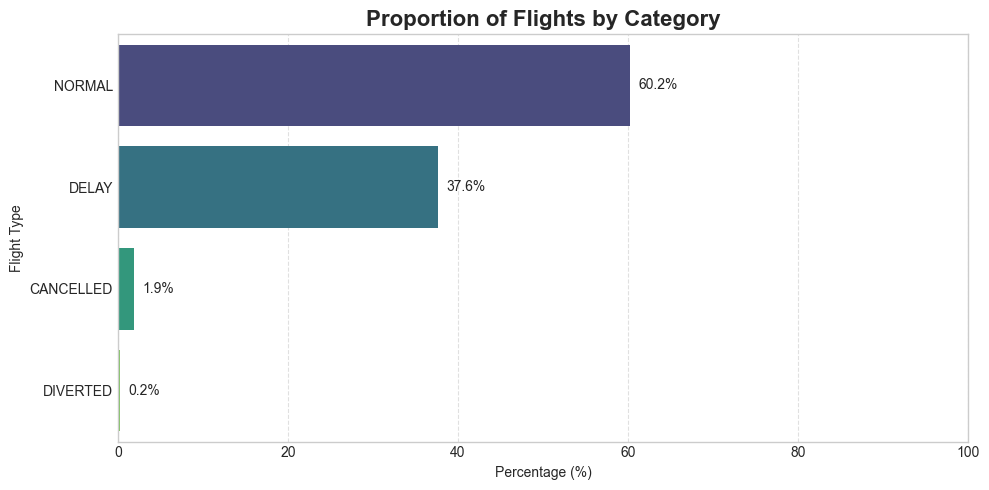

In [163]:
problem_counts = df[problematic_columns].sum()

total_flights = len(df)
total_problematic_flights = df[problematic_columns].any(axis=1).sum()
normal_flights_count = total_flights - total_problematic_flights

all_counts = problem_counts.to_dict()
all_counts["NORMAL"] = normal_flights_count
summary_df = pd.DataFrame(all_counts.items(), columns=["Problem_Type", "Count"])

summary_df["Percentage"] = (summary_df["Count"] / total_flights) * 100
summary_df.loc[summary_df['Problem_Type'] == 'DEP_DEL15', 'Problem_Type'] = 'DELAY'
summary_df_sorted = summary_df.sort_values(by="Percentage", ascending=False)

plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=summary_df_sorted,
    x="Percentage",
    y="Problem_Type",
    hue="Problem_Type",
    palette="viridis",
    legend=False
)

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1, p.get_y() + p.get_height() / 2.,
            f'{width:.1f}%',
            ha="left", va="center")

plt.title("Proportion of Flights by Category", fontsize=16, fontweight="bold")
plt.xlabel("Percentage (%)")
plt.ylabel("Flight Type")
plt.xlim(0, 100)
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [164]:
# Top 10 airlines with most problems (delays, cancellations, diversions)
results_airline = []
for col in problematic_columns:
    top_prob_airlines = (
        df.groupby("AIRLINE_Description")[col].sum().nlargest(10))
    results_airline.append(top_prob_airlines.rename(col))
summary_table_airline = pd.concat(results_airline, axis=1).fillna(0).astype(int)
summary_table_airline = summary_table_airline.sort_values("DELAY", ascending=False)

summary_table_airline.head(10)

,DELAY,CANCELLED,DIVERTED
AIRLINE_Description,,,
SOUTHWEST AIRLINES CO.,40279,3234,197
AMERICAN AIRLINES INC.,29391,1417,128
DELTA AIR LINES INC.,26647,586,169
UNITED AIR LINES INC.,21920,415,140
SKYWEST AIRLINES INC.,19391,1669,299
SPIRIT AIR LINES,9715,507,0
JETBLUE AIRWAYS,9322,0,77
ALASKA AIRLINES INC.,7701,280,100
ENVOY AIR,7528,482,42


In [165]:
# Average departure delay by airline
avg_delay_airline = df.groupby("AIRLINE_Description")["DELAY_OVERALL"].mean().reset_index()
avg_delay_airline = avg_delay_airline.sort_values(by="DELAY_OVERALL", ascending=False)

avg_delay_airline.head(5)

,AIRLINE_Description,DELAY_OVERALL
6,FRONTIER AIRLINES INC.,27.184720
1,ALLEGIANT AIR,23.734301
13,SPIRIT AIR LINES,20.860898
8,JETBLUE AIRWAYS,20.785668
2,AMERICAN AIRLINES INC.,18.576048


In [166]:
# Top 10 city origin with most problems (delays, cancellations, diversions)
results_city = []
for col in problematic_columns:
    top_prob_airlines = (df.groupby("ORIGIN_CITY")[col].sum().nlargest(10))
    results_city.append(top_prob_airlines.rename(col))
summary_table_city = pd.concat(results_city, axis=1).fillna(0).astype(int)
summary_table_city = summary_table_city.sort_values("DELAY", ascending=False)

summary_table_city.head(5)

,DELAY,CANCELLED,DIVERTED
ORIGIN_CITY,,,
"CHICAGO, IL",11412,570,65
"DENVER, CO",10666,786,65
"ATLANTA, GA",10316,0,68
"DALLAS/FORT WORTH, TX",7919,743,77
"NEW YORK, NY",7904,379,51


In [167]:
# Average departure delay by airline
avg_delay_city = df.groupby("ORIGIN_CITY")["DELAY_OVERALL"].mean().reset_index()
avg_delay_city = avg_delay_city.sort_values(by="DELAY_OVERALL", ascending=False)

avg_delay_city.head(5)

,ORIGIN_CITY,DELAY_OVERALL
257,"RIVERTON/LANDER, WY",68.774194
246,"PRESCOTT, AZ",48.868852
221,"NORTH BEND/COOS BAY, OR",47.333333
64,"CLARKSBURG/FAIRMONT, WV",46.400000
97,"ESCANABA, MI",46.245902


In [168]:
# Top 10 state origin with most problems (delays, cancellations, diversions)
results_state = []
for col in problematic_columns:
    top_prob_airlines = (df.groupby("ORIGIN_STATE")[col].sum().nlargest(10))
    results_state.append(top_prob_airlines.rename(col))
summary_table_city = pd.concat(results_state, axis=1).fillna(0).astype(int)
summary_table_city = summary_table_city.sort_values("DELAY", ascending=False)

summary_table_city.head(5)

,DELAY,CANCELLED,DIVERTED
ORIGIN_STATE,,,
CA,21625,1137,236
FL,20500,786,114
TX,19886,1714,144
CO,12226,1044,87
IL,11788,597,69


In [169]:
# Average departure delay by airline
avg_delay_state = df.groupby("ORIGIN_STATE")["DELAY_OVERALL"].mean().reset_index()
avg_delay_state = avg_delay_state.sort_values(by="DELAY_OVERALL", ascending=False)

avg_delay_state.head(5)

,ORIGIN_STATE,DELAY_OVERALL
52,WY,34.567086
27,ND,29.532431
41,SD,25.715360
51,WV,23.706667
5,CO,22.288857


### b. Applying measures of central tendency and dispersion measures

In [170]:
analysis_columns = ['CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'CRS_ELAPSED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'FL_DAY', 'DELAY_TOTAL', 'DELAY_OVERALL']

In [171]:
central_tendency_dic = {}

for col in analysis_columns:
    if col in df.columns:
        mean = df[col].mean()
        median = df[col].median()
        mode = df[col].mode()
        mode_val = mode.iloc[0] if not mode.empty else None
        std_dev = df[col].std()
        central_tendency_dic[col] = {
            'Mean': mean,
            'Median': median,
            'Mode': mode_val,
            'Standard Deviation': std_dev
        }

df_central_tendency_dic = pd.DataFrame(central_tendency_dic).T

df_central_tendency_dic

,Mean,Median,Mode,Standard Deviation
CRS_DEP_TIME,1327.415986,1320.0,600.0,489.903054
DEP_TIME,1334.224064,1327.0,555.0,502.485952
DEP_DELAY,12.937247,-2.0,-5.0,55.435947
TAXI_OUT,18.334566,15.0,13.0,10.624460
WHEELS_OFF,1358.483518,1341.0,611.0,503.858558
WHEELS_ON,1471.856121,1509.0,1627.0,532.185174
TAXI_IN,8.038000,6.0,4.0,6.416574
CRS_ARR_TIME,1497.177997,1520.0,2359.0,515.237173
ARR_TIME,1474.041206,1512.0,1150.0,538.082055
ARR_DELAY,7.776393,-5.0,-12.0,57.396809


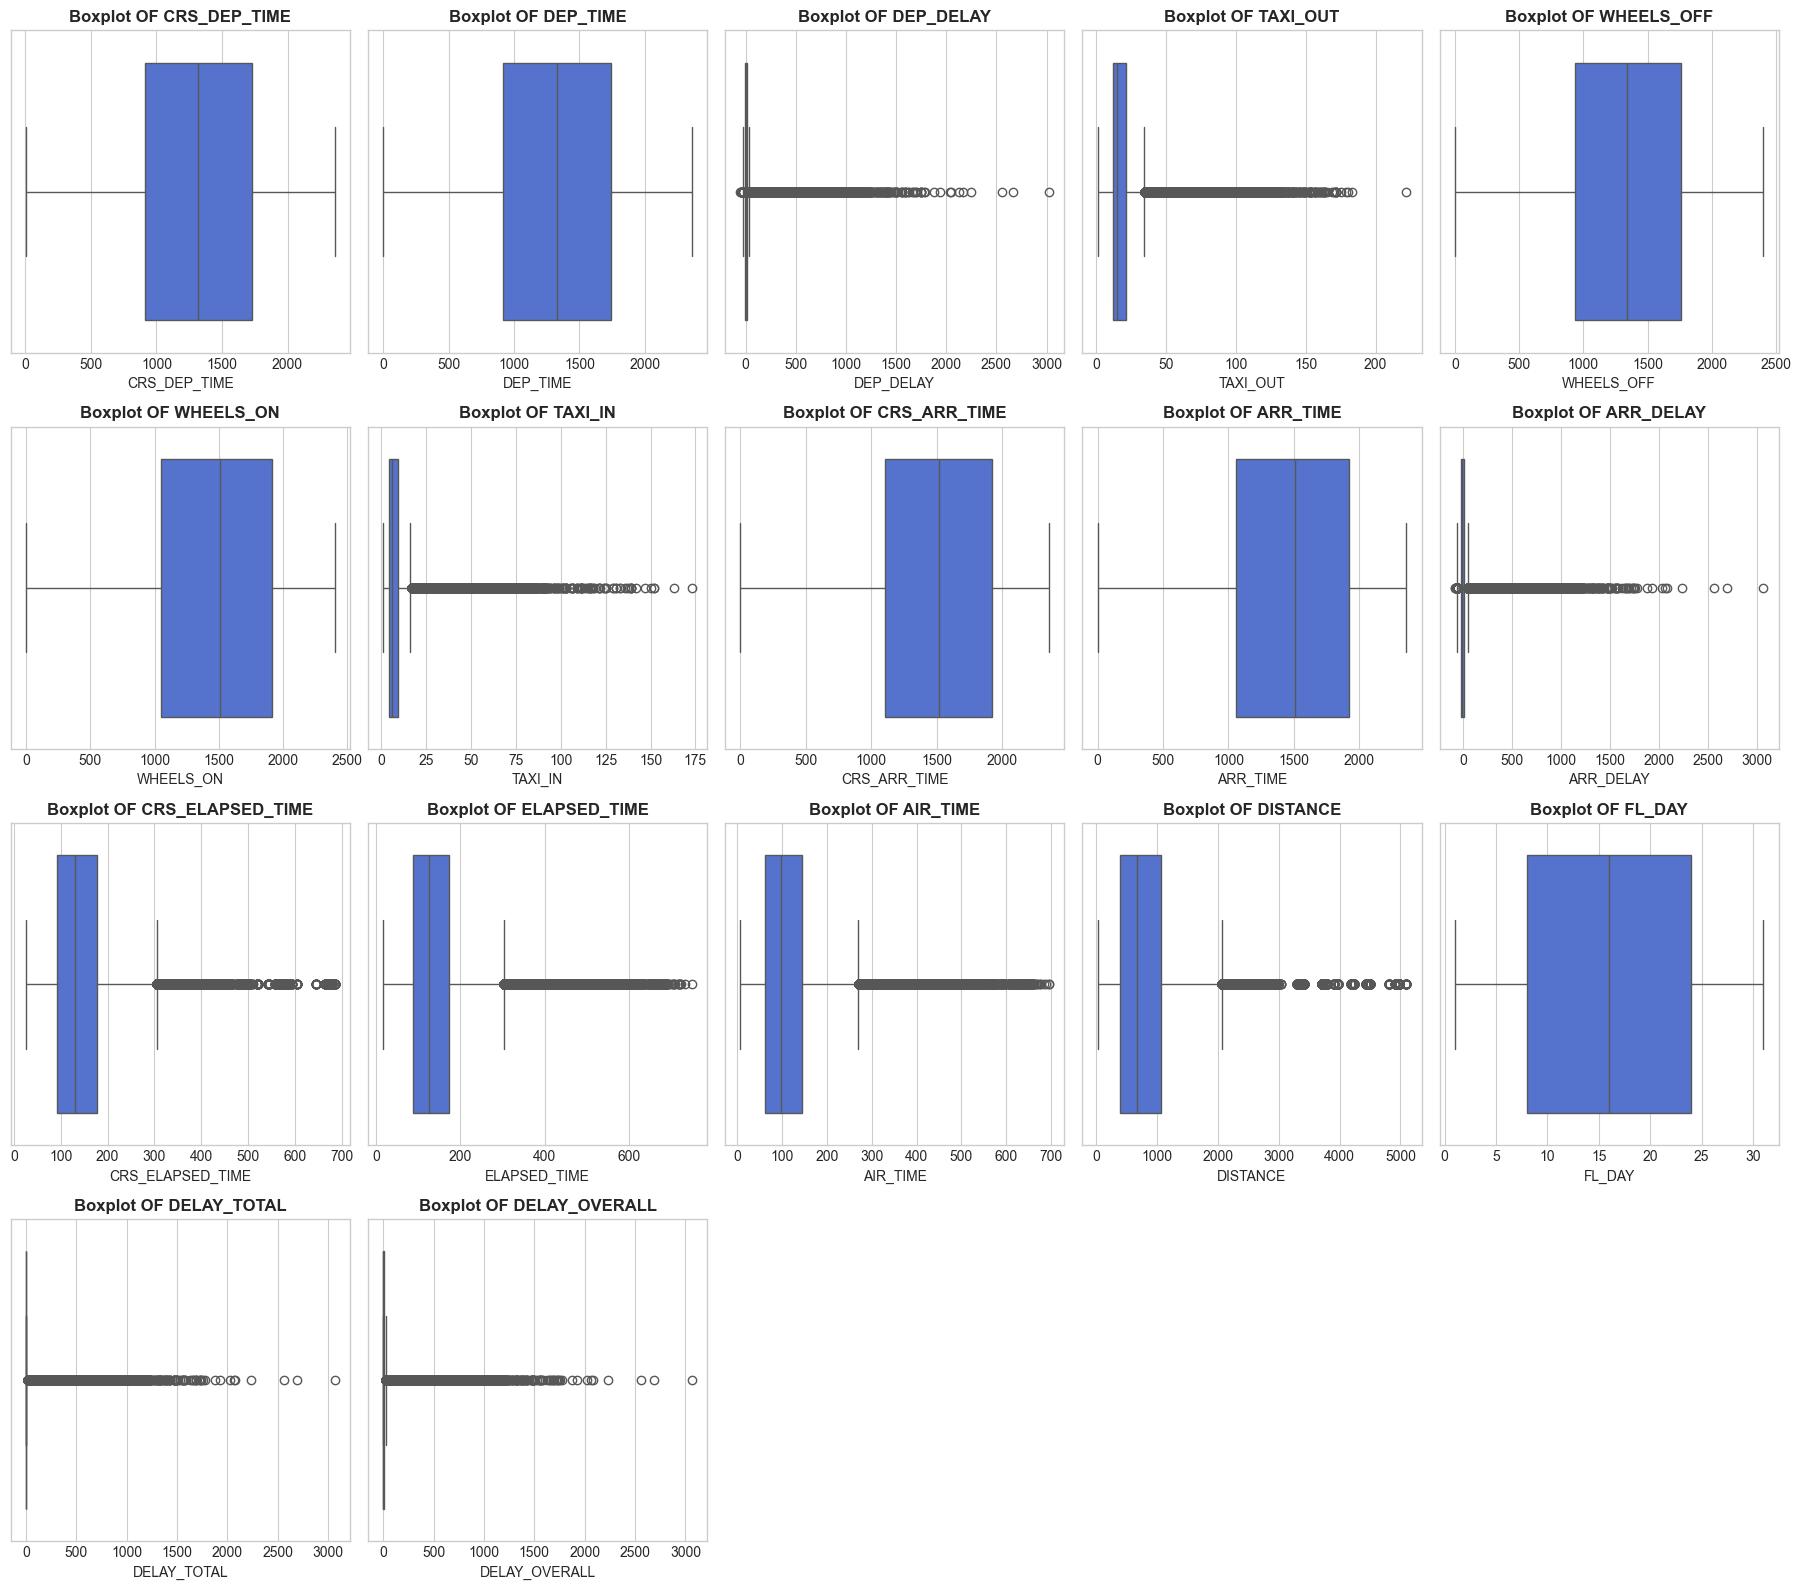

In [172]:
# Boxplots
n_cols = 5
n_rows = math.ceil(len(analysis_columns) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()
for i, col in enumerate(analysis_columns):
    if col in df.columns:
        sns.boxplot(x=df[col], color="royalblue", ax=axes[i])
        axes[i].set_title(f"Boxplot OF {col}", fontsize=12, fontweight="bold")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("")
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### c. Displaying distribution

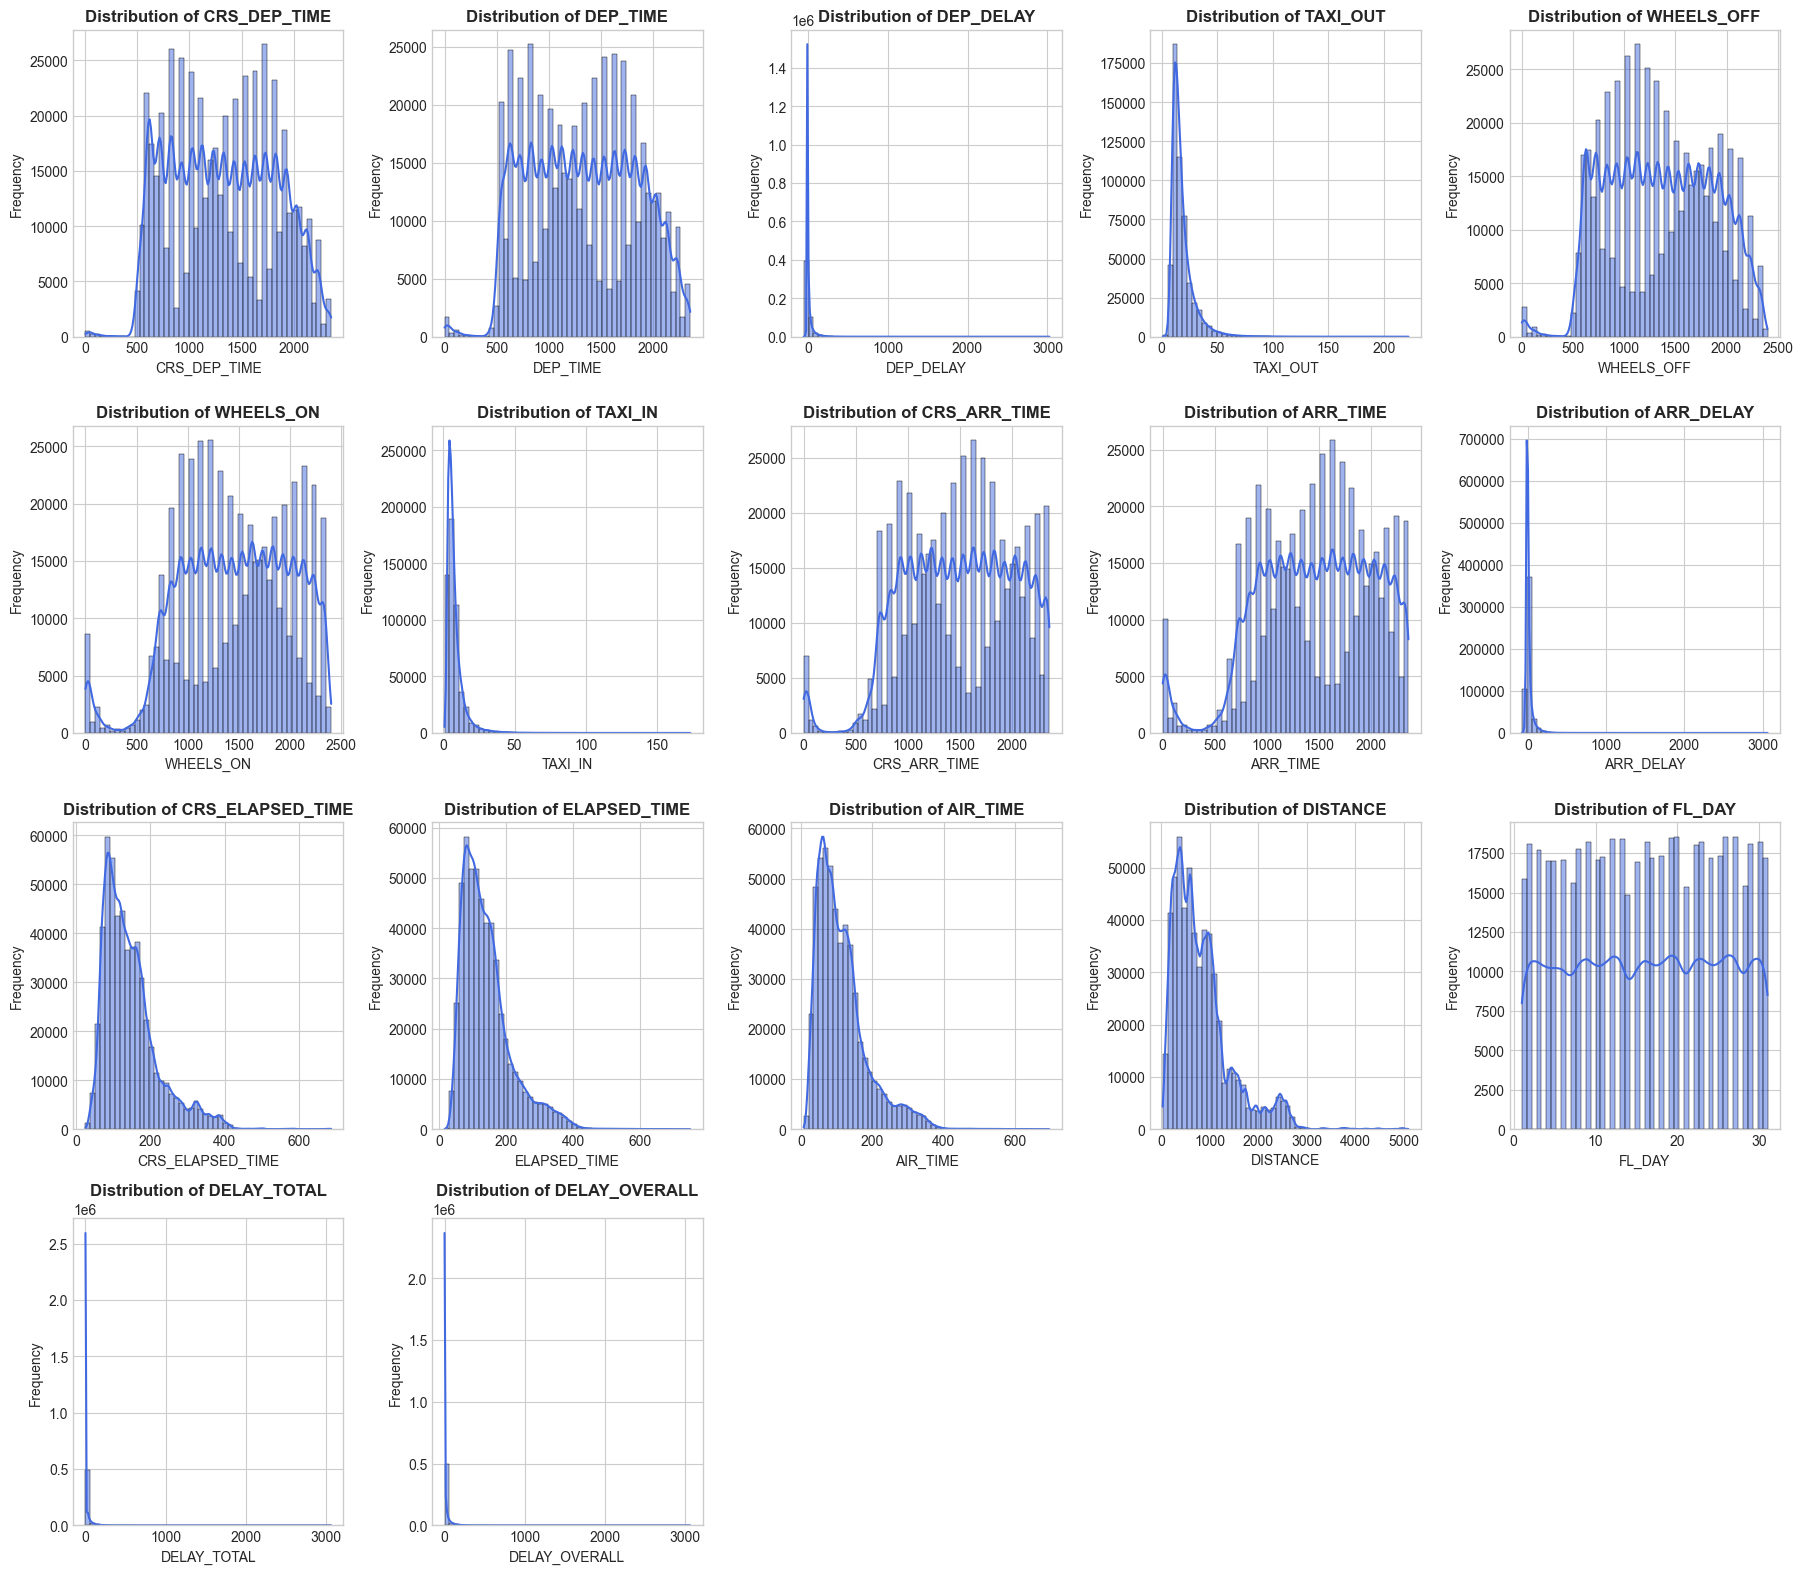

In [173]:
# Histograms
n_cols = 5
n_rows = math.ceil(len(analysis_columns) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()
for i, col in enumerate(analysis_columns):
    if col in df.columns:
        sns.histplot(df[col], bins=50, kde=True, color="royalblue", ax=axes[i])
        axes[i].set_title(f"Distribution of {col}", fontsize=12, fontweight="bold")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Frequency")
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### d. Calculating quarters, tenths or percents

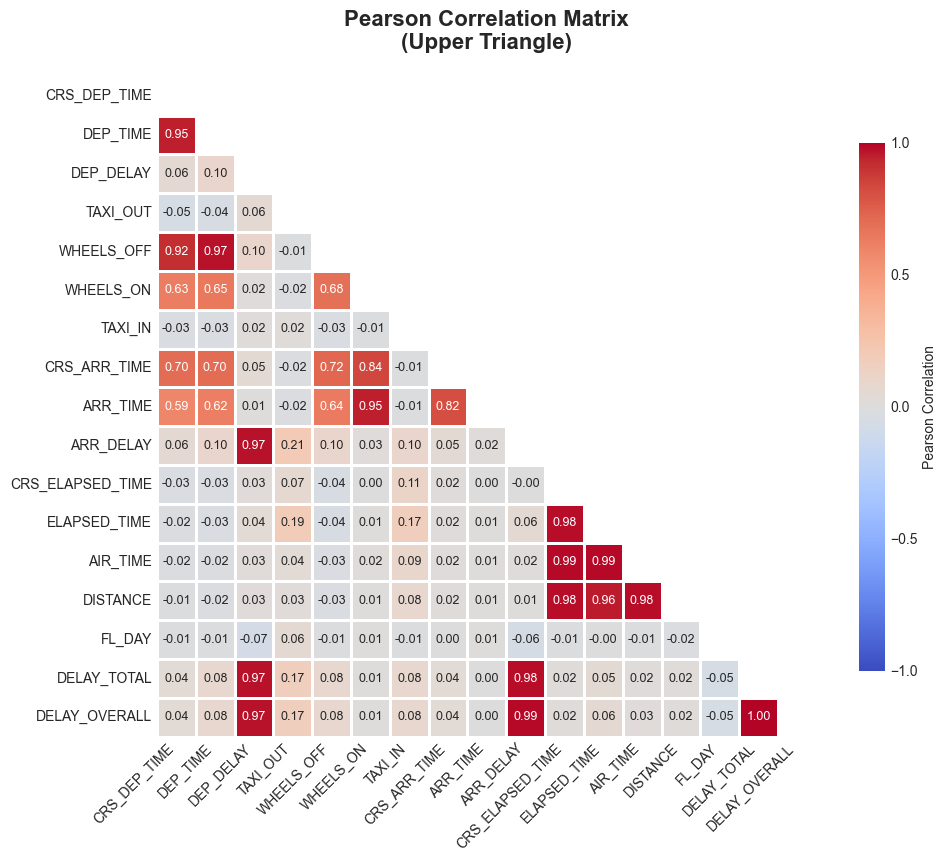

In [174]:
# Pearson correlation matrix and Hotmap
correlation_matrix = df[analysis_columns].corr(method='pearson')

plt.figure(figsize=(len(analysis_columns) * 0.6, len(analysis_columns) * 0.5))

mask_low_corr = (np.abs(correlation_matrix) < 0.1) & (correlation_matrix != 1.0)

sns.heatmap(
    correlation_matrix.round(2),
    mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.8,
    square=True,
    center=0,
    vmin=-1, vmax=1,
    cbar_kws={
        "shrink": 0.8,
        "label": "Pearson Correlation",
        "ticks": [-1, -0.5, 0, 0.5, 1]
    },
    annot_kws={
        "fontsize": 9
    }
)

plt.title("Pearson Correlation Matrix\n(Upper Triangle)", 
          fontsize=16, fontweight="bold", pad=20)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.grid(False)

plt.tight_layout()
plt.show()

## 4. Apply analysis technique: Flight segmentation

### * Functions for plot

In [175]:
def plot_multiple_bar_metrics(df, metrics_list, group_col, title):
    """
    Plota múltiplos gráficos de barras para as métricas fornecidas, com base no modelo
    padronizado.

    Args:
        df (pd.DataFrame): O DataFrame de entrada.
        metrics_list (list): Uma lista com os nomes das colunas de métricas para plotar.
        group_col (str): O nome da coluna para agrupar.
        title (str): O título principal do gráfico.
    """
    plt.style.use('seaborn-v0_8-whitegrid')

    num_plots = len(metrics_list)
    fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 7), sharey=False)

    if num_plots == 1:
        axes = [axes]

    for i, col in enumerate(metrics_list):
        grouped_data = df.groupby(group_col, observed=True)[col].mean().reset_index()

        sns.barplot(
            data=grouped_data,
            x=group_col,
            y=col,
            hue=group_col,
            palette="viridis",
            legend=False,
            ax=axes[i]
        )
        
        mean_val = grouped_data[col].mean()
        axes[i].axhline(
            mean_val,
            color="red",
            linestyle="--",
            linewidth=1.2,
            label=f"Mean: {mean_val:.2f}"
        )

        axes[i].set_title(f"{col.replace('_', ' ').title()}", fontsize=18, fontweight="bold")
        axes[i].set_xlabel(group_col.replace('_', ' ').title(), fontsize=14)
        axes[i].set_ylabel("Mean (min)" if "DELAY" in col.upper() else "Porcentagem de Voos (%)", fontsize=14)

        x_labels = grouped_data[group_col]
        axes[i].set_xticks(range(len(x_labels)))
        axes[i].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=12)

        axes[i].tick_params(axis='y', labelsize=12)
        axes[i].grid(axis="y", linestyle="--", alpha=0.6)
        axes[i].legend(fontsize=12)

    fig.suptitle(title, fontsize=20, fontweight='bold', y=1.03)
    plt.tight_layout()
    plt.show()

In [176]:
def plot_bar_mean_delay(df, group_col, title):
    """
    Plota um gráfico de barras da média de atraso para uma coluna de agrupamento específica.

    Args:
        df (pd.DataFrame): O DataFrame de entrada.
        group_col (str): A coluna para categorizar e agrupar (ex: 'AIRLINE_Description').
        title (str): O título do gráfico.
    """
    delay_by_group = df.groupby(group_col, observed=True)["DELAY_OVERALL"].mean().reset_index()

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    sns.barplot(
        data=delay_by_group,
        x=group_col,
        y="DELAY_OVERALL",
        hue=group_col,
        palette="viridis",
        legend=False
    )

    mean_val = delay_by_group["DELAY_OVERALL"].mean()
    ax.axhline(mean_val, color="red", linestyle="--", linewidth=1.2, label=f"Percentage of Flights: {mean_val:.2f} min")

    ax.set_title(title, fontsize=18, fontweight="bold")
    ax.set_xlabel(group_col.replace('_', ' ').title(), fontsize=14)
    ax.set_ylabel("Mean delay (min)", fontsize=14)

    x_labels = delay_by_group[group_col]
    ax.set_xticks(range(len(x_labels)))
    ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=12)

    ax.tick_params(axis='y', labelsize=12)
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    ax.legend(fontsize=12)
    
    plt.tight_layout()
    plt.show()

In [177]:

def plot_line_multiple_metrics_by_category(df, metrics_list, group_col, title):
    """
    Plots multiple line graphs for the provided metrics, grouped by category.

    Args:
        df(pd.DataFrame): The input DataFrame.
        metrics_list(list): A list of the names of the metrics columns to plot.
        group_col(str): The column to categorize and group by (e.g., 'TIME_HOUR').
        title(str): The main title of the figure.
    """
    plt.style.use('seaborn-v0_8-whitegrid')

    grouped_metrics = df.groupby(group_col, observed=True)[metrics_list].mean().reset_index()

    num_plots = len(metrics_list)

    fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5), sharey=False)

    if num_plots == 1:
        axes = [axes]

    for i, col in enumerate(metrics_list):
        sns.lineplot(
            data=grouped_metrics,
            x=group_col,
            y=col,
            marker="o",
            color="royalblue",
            ax=axes[i]
        )

        axes[i].fill_between(
            grouped_metrics[group_col],
            grouped_metrics[col],
            color="royalblue",
            alpha=0.2
        )

        mean_val = grouped_metrics[col].mean()
        axes[i].axhline(
            mean_val,
            color="red",
            linestyle="--",
            linewidth=1.2,
            label=f"Mean: {mean_val:.3f}"
        )

        axes[i].set_title(f"{col.replace('_', ' ').title()}", fontsize=12, fontweight="bold")
        axes[i].set_xlabel(group_col.replace('_', ' ').title())
        axes[i].set_ylabel("Percentage of Flights")
        axes[i].grid(axis="y", linestyle="--", alpha=0.6)
        axes[i].legend()

    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.03)

    plt.tight_layout()
    plt.show()

In [178]:
def plot_line_by_category(df, group_col, title):
    """
    Plots a line graph of the average lag for a specific grouping column.

    Args:
        df(pd.DataFrame): The input DataFrame.
        group_col(str): The column to categorize and group by (e.g., 'TIME_HOUR').
        title(str): The title of the graph.
    """
    delay_by_group = df.groupby(group_col, observed=True)["DELAY_OVERALL"].mean().reset_index()


    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))

    sns.lineplot(
        data=delay_by_group,
        x=group_col,
        y="DELAY_OVERALL",
        marker="o",
        color="royalblue",
        markersize=6,
        ax=ax
    )

    ax.fill_between(delay_by_group[group_col], delay_by_group["DELAY_OVERALL"], color="skyblue", alpha=0.4)

    mean_val = delay_by_group["DELAY_OVERALL"].mean()
    ax.axhline(
        mean_val,
        color="red",
        linestyle="--",
        linewidth=1.2,
        label=f"Mean: {mean_val:.2f} min"
    )

    ax.set_title(title, fontsize=18, fontweight="bold")
    ax.set_xlabel(group_col.replace('_', ' ').title(), fontsize=14)
    ax.set_ylabel("Mean delay (min)", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)

    ax.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


### a. By flight distance

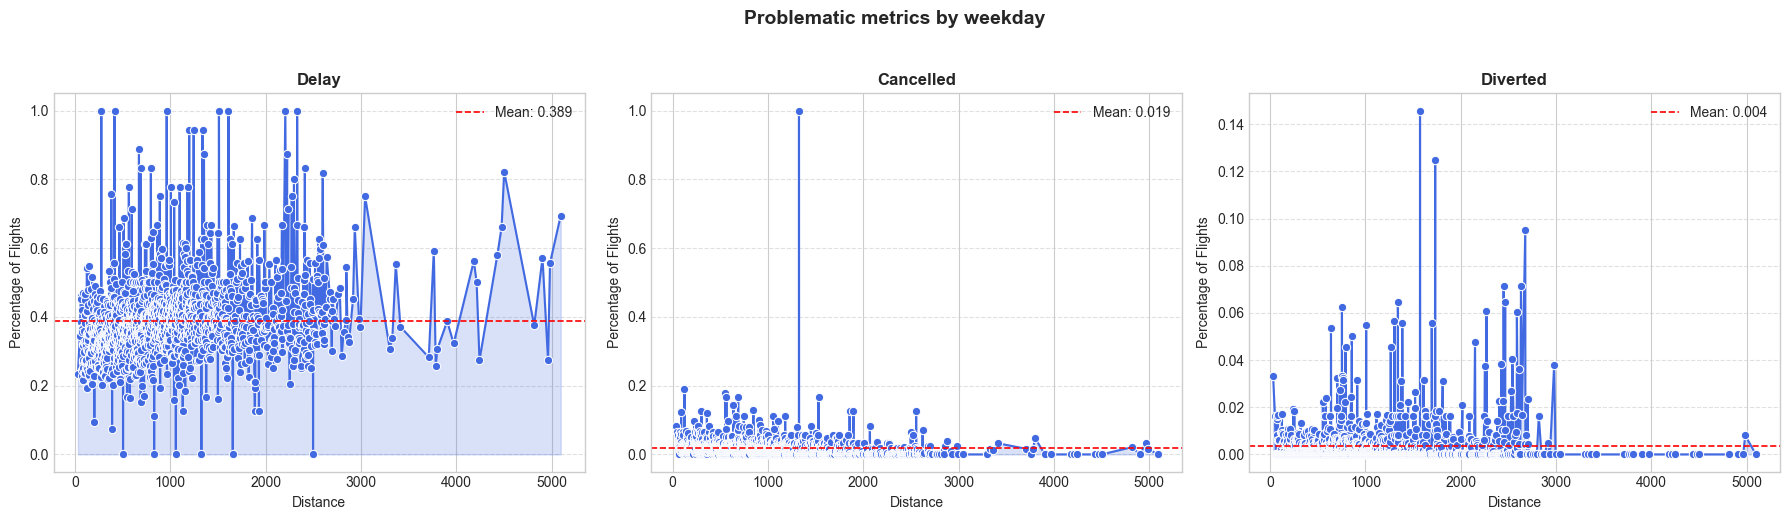

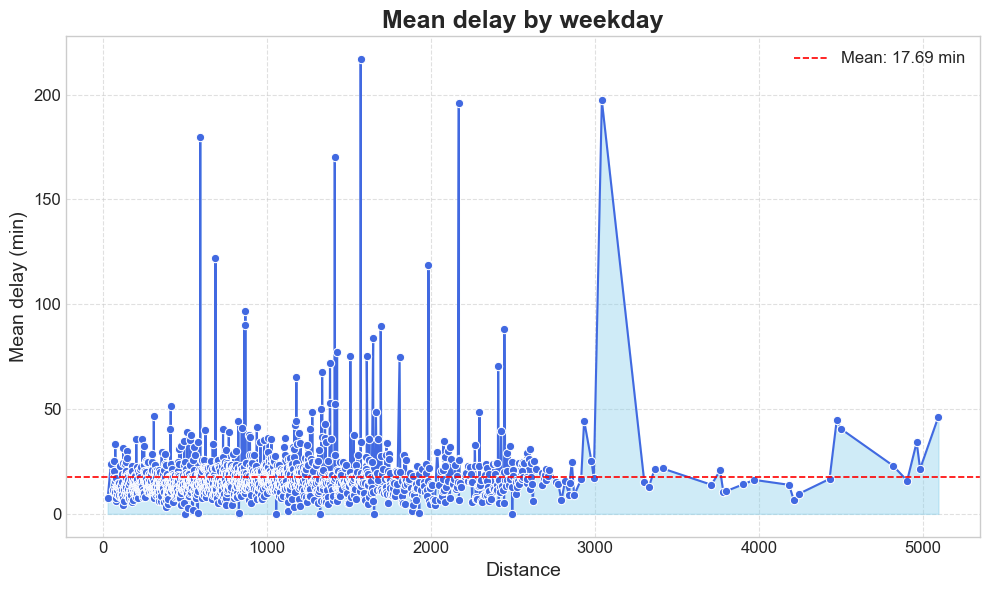

In [179]:
plot_line_multiple_metrics_by_category(df, problematic_columns, "DISTANCE", "Problematic metrics by weekday")
plot_line_by_category(df, "DISTANCE", "Mean delay by weekday")

### b. By time period of day

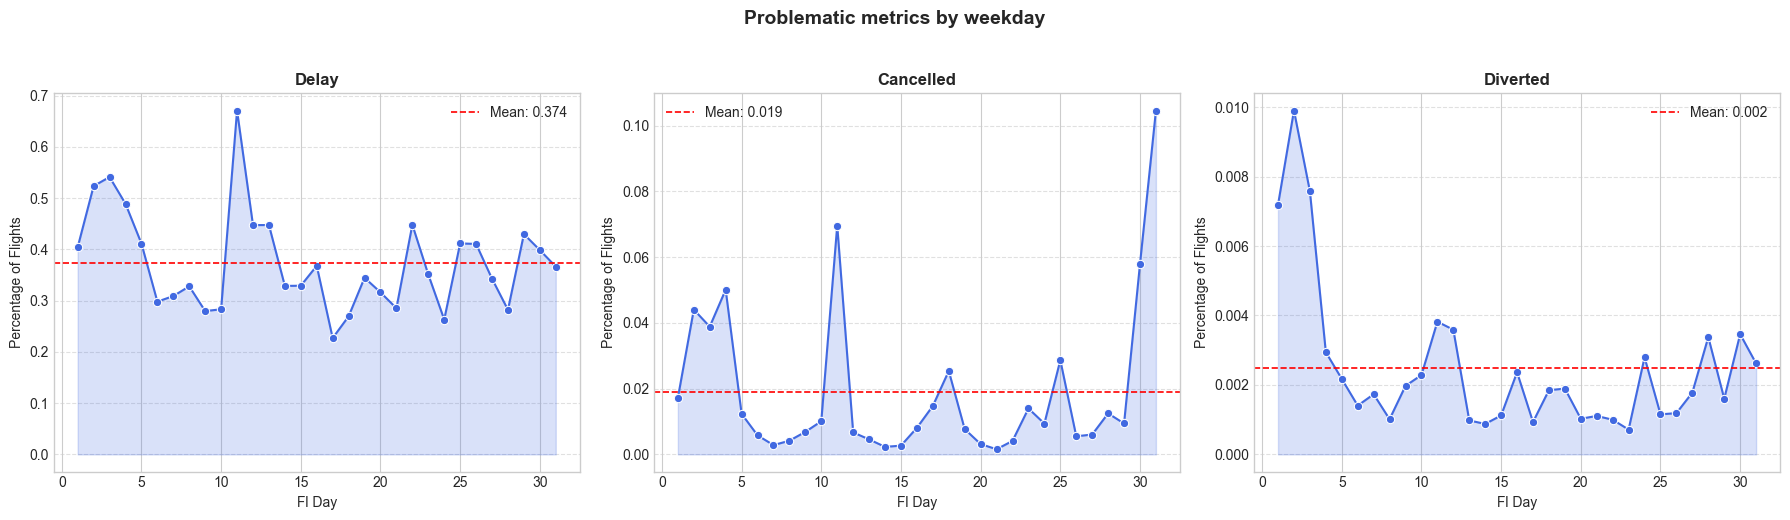

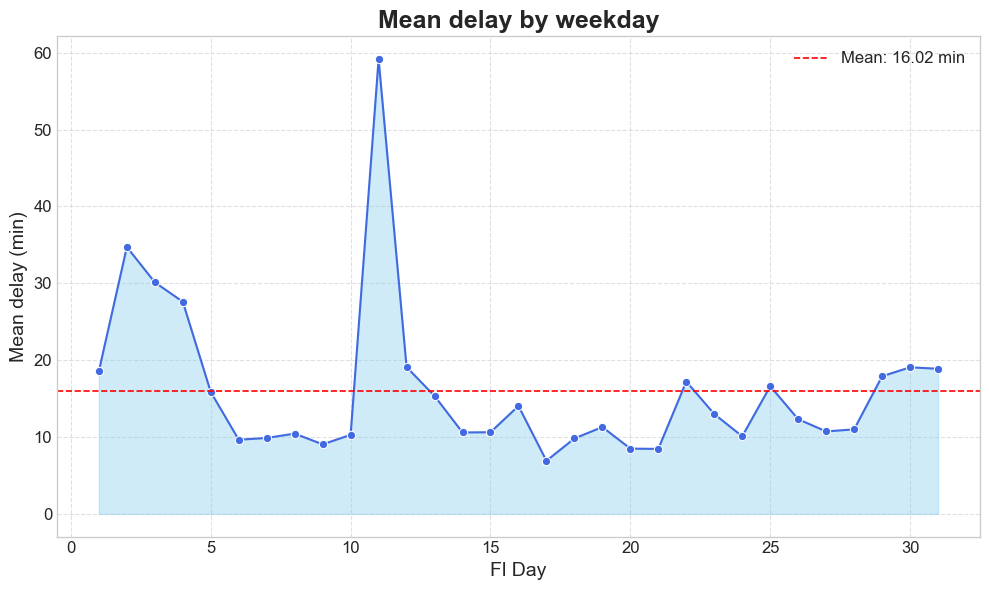

In [180]:
plot_line_multiple_metrics_by_category(df, problematic_columns, "FL_DAY", "Problematic metrics by weekday")
plot_line_by_category(df, "FL_DAY", "Mean delay by weekday")

### c. By weekday

In [181]:
weekday_order = ["Segunda-feira", "Terça-feira", "Quarta-feira", "Quinta-feira", "Sexta-feira", "Sábado", "Domingo"]
df["DAY_OF_WEEK"] = pd.Categorical(df["DAY_OF_WEEK"], categories=weekday_order, ordered=True)

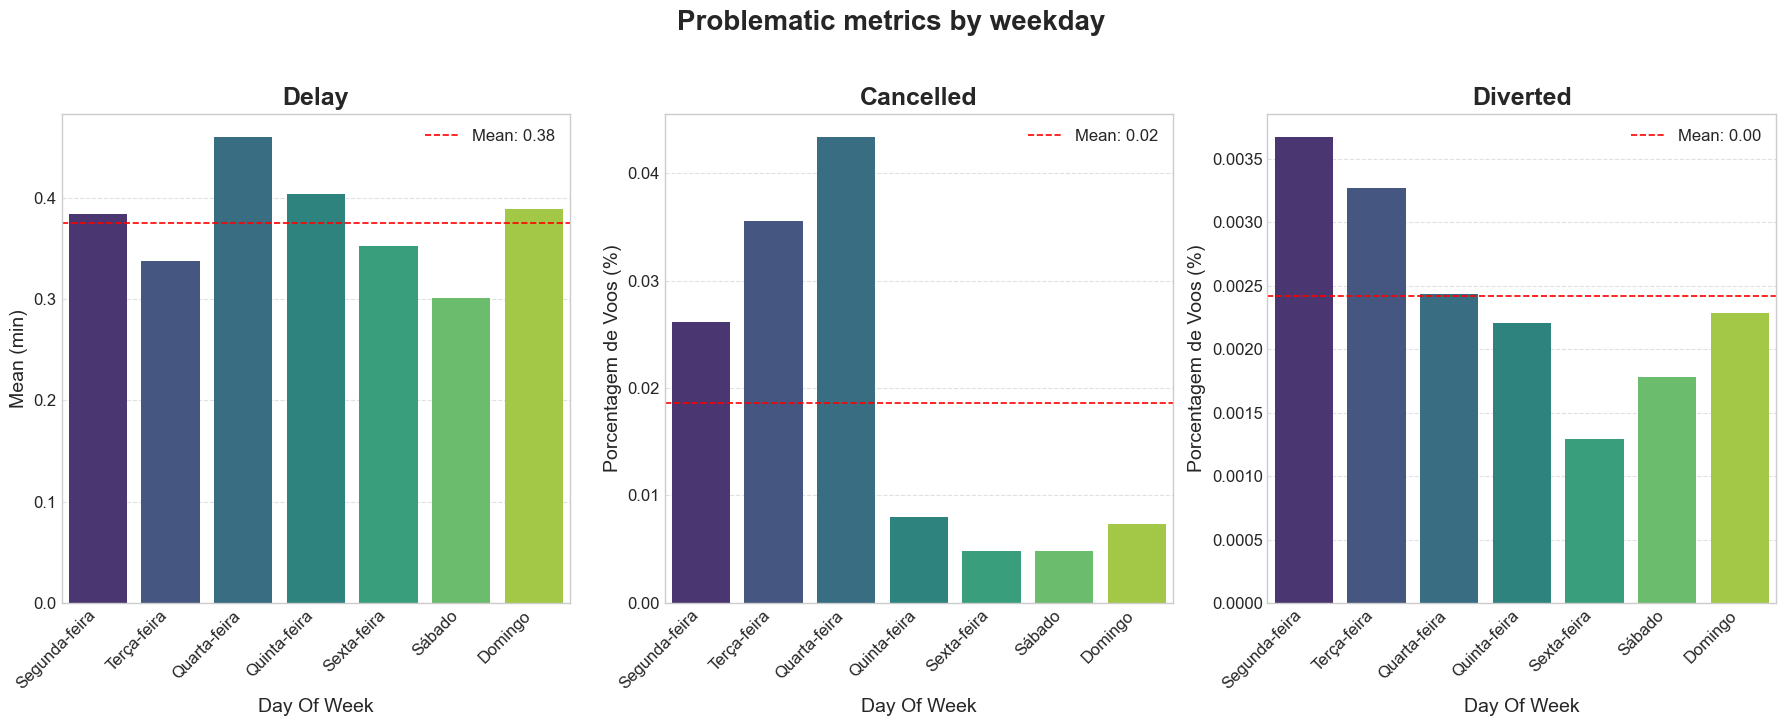

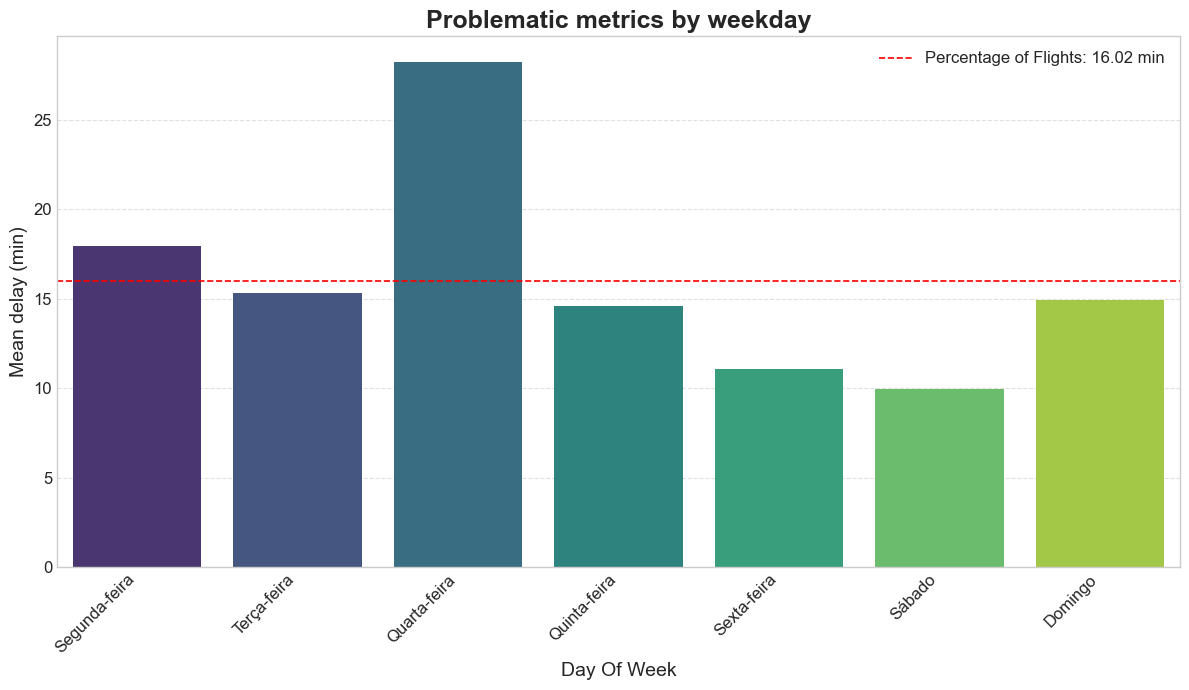

In [182]:
plot_multiple_bar_metrics(df, problematic_columns, "DAY_OF_WEEK", "Problematic metrics by weekday")
plot_bar_mean_delay(df, "DAY_OF_WEEK", "Problematic metrics by weekday")

In [183]:
# period_day_order = ["Early Morning", "Morning", "Afternoon", "Evening"]
period_day_order = ["Madrugada", "Manhã", "Tarde", "Noite"]
df["TIME_PERIOD"] = pd.Categorical(df["TIME_PERIOD"], categories=period_day_order, ordered=True)

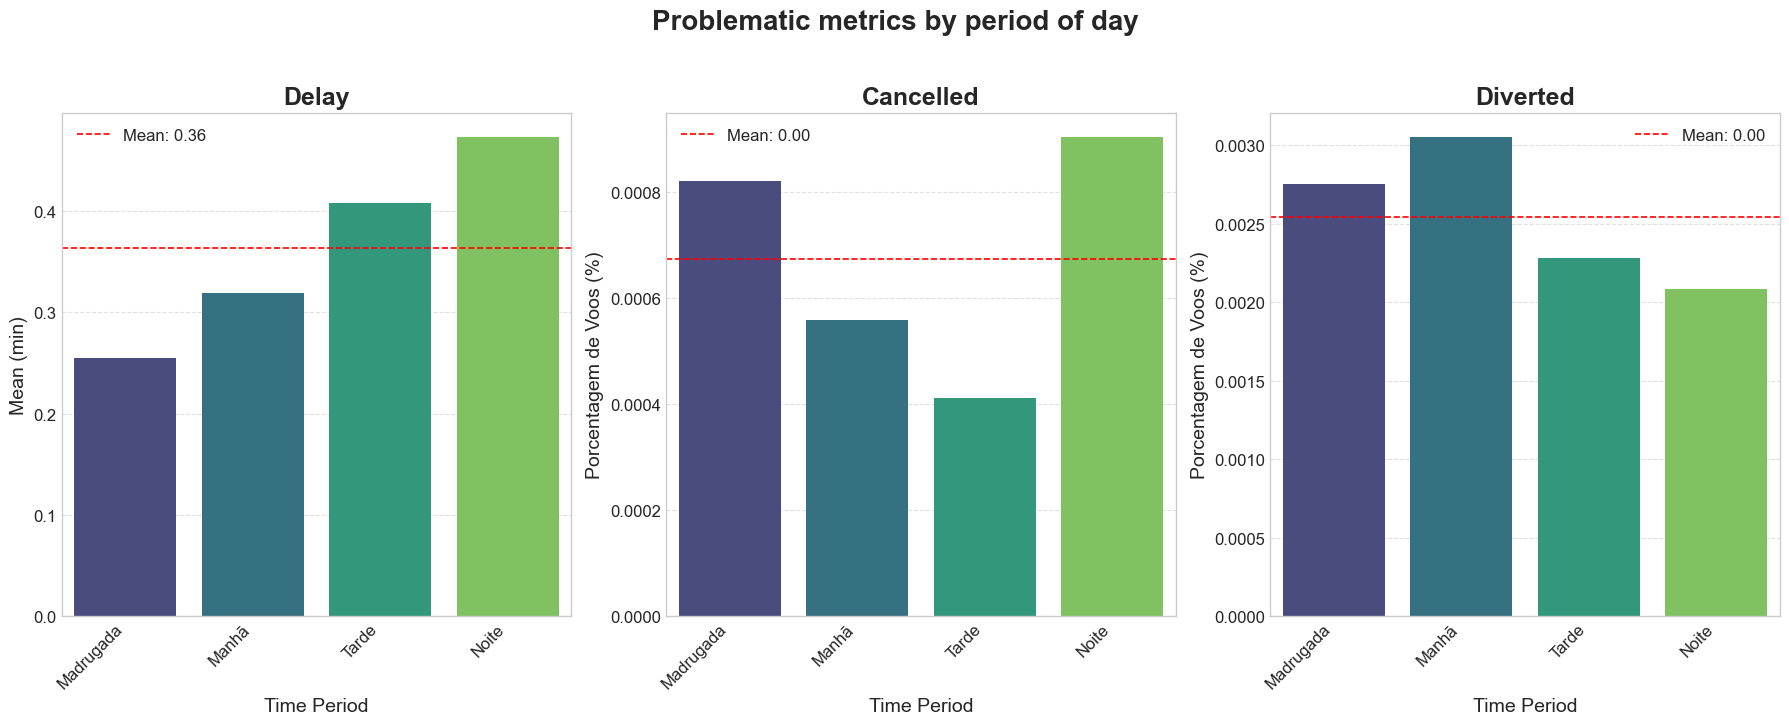

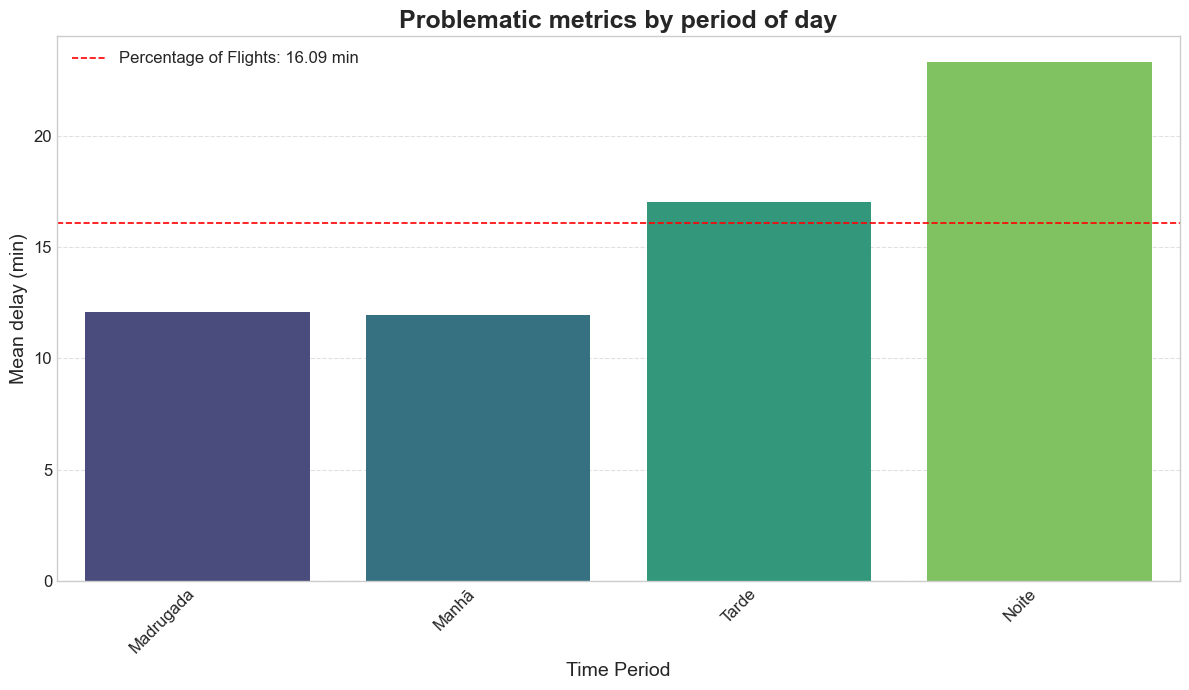

In [184]:
plot_multiple_bar_metrics(df, problematic_columns, "TIME_PERIOD", "Problematic metrics by period of day")
plot_bar_mean_delay(df, "TIME_PERIOD", "Problematic metrics by period of day")

### d. By hour of day

In [185]:
df['TIME_HOUR'] = pd.cut(df['DEP_TIME'],
                         bins=range(0, 2401, 100),
                         labels=range(24),
                         right=False)

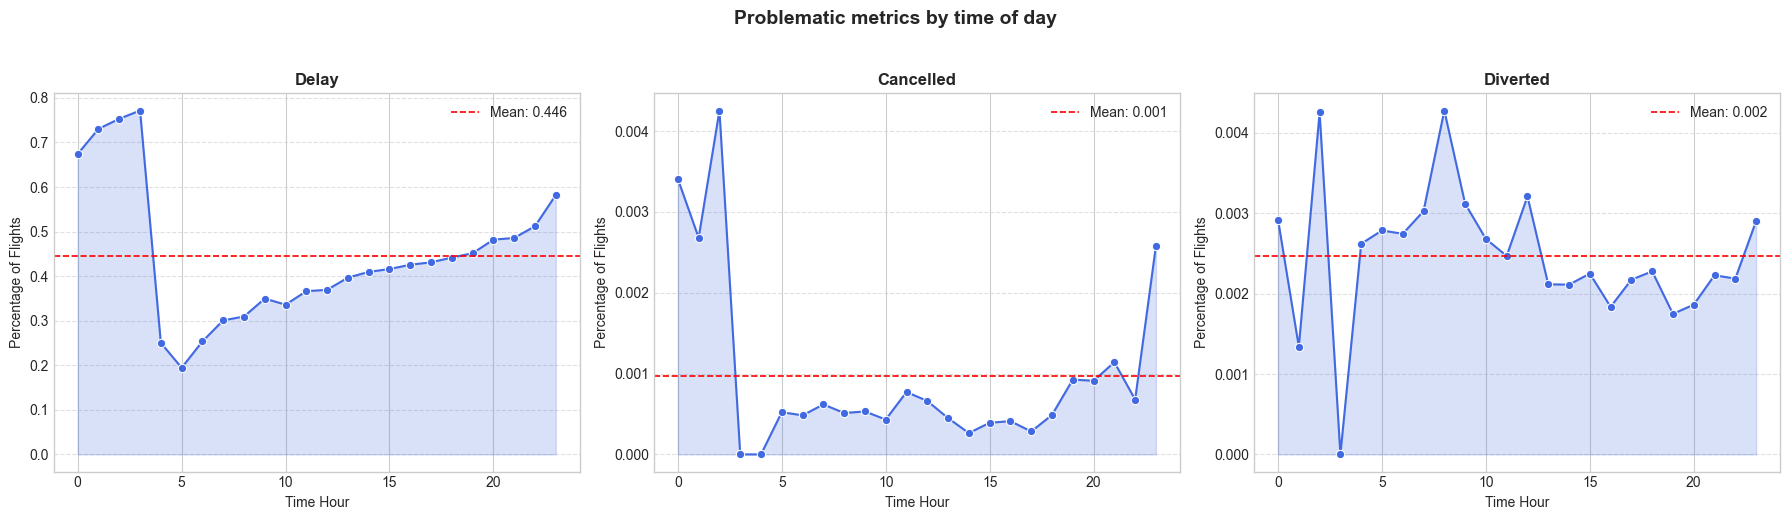

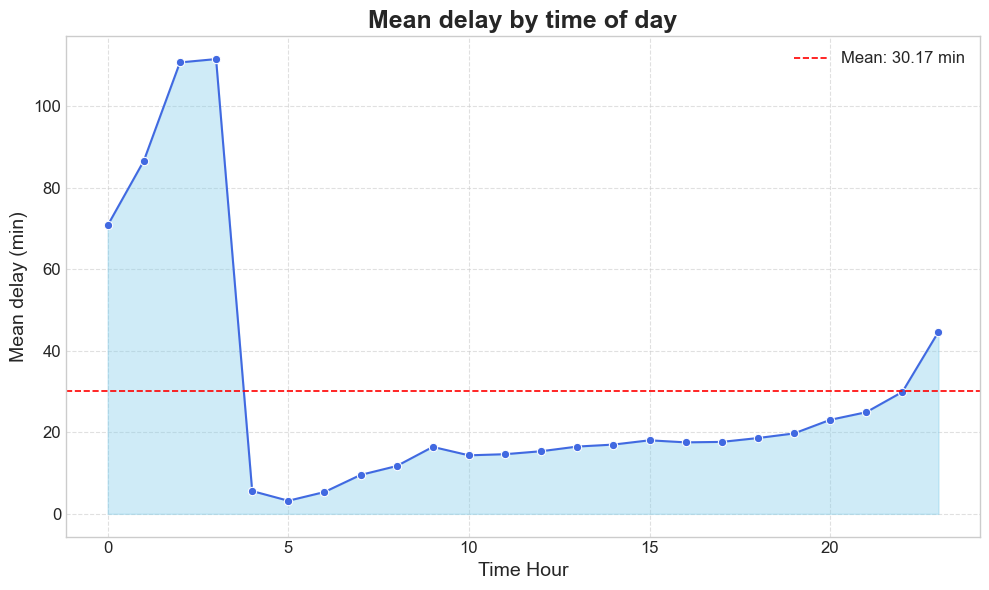

In [186]:
plot_line_multiple_metrics_by_category(df, problematic_columns, "TIME_HOUR", "Problematic metrics by time of day")
plot_line_by_category(df, 'TIME_HOUR', "Mean delay by time of day")

## 5. Apply analysis technique: Validate hypotheses and calculate relative risk

### * Functions to hypotheses test

In [187]:
def perform_t_test(group1_data, group2_data, alpha=0.05):
    """
    Performs an independent samples t-test.

    Args:
        group1_data (pd.Series): Data for the first group.
        group2_data (pd.Series): Data for the second group.
        alpha (float): Significance level.

    Returns:
        tuple: (t_statistic, p_value, significant_difference)
    """
    t_statistic, p_value = ttest_ind(group1_data.dropna(), group2_data.dropna(), equal_var=False) # Welch's t-test
    significant_difference = p_value < alpha
    return t_statistic, p_value, significant_difference

In [188]:
def perform_chi2_test(contingency_table, alpha=0.05):
    """
    Performs a Chi-squared test of independence.

    Args:
        contingency_table (pd.DataFrame): Contingency table.
        alpha (float): Significance level.

    Returns:
        tuple: (chi2_statistic, p_value, significant_association)
    """
    chi2_statistic, p_value, _, _ = chi2_contingency(contingency_table)
    significant_association = p_value < alpha
    return chi2_statistic, p_value, significant_association

In [189]:
def validate_mean_hypothesis(df, group_col, target_col, focus_values, h1_description, alpha=0.05):
    """
    Validates a hypothesis about the mean of a target variable between a focus group and others.

    Args:
        df (pd.DataFrame): The input DataFrame.
        group_col (str): The column used for grouping (e.g., 'AIRLINE_TYPE', 'ORIGIN_CITY').
        target_col (str): The numerical column for which the mean is compared (e.g., 'DEP_DELAY').
        focus_values (list): A list of values defining the focus group.
        h1_description (str): Description of the alternative hypothesis.
        alpha (float): Significance level.
    """
    print(f"\n🔴 Hipótese: {h1_description}")

    df_copy = df.copy()
    df_copy['is_focus_group'] = df_copy[group_col].isin(focus_values)

    group_focus = df_copy[df_copy['is_focus_group'] == True][target_col]
    group_others = df_copy[df_copy['is_focus_group'] == False][target_col]

    if group_focus.empty or group_others.empty:
        print("⚠️ Não há dados suficientes para comparar os grupos.")
        return

    t_statistic, p_value, significant_difference = perform_t_test(group_focus, group_others, alpha)

    print(f"T-statistic: {t_statistic:.4f} | p-value: {p_value:.4f}")

    if significant_difference:
        print(f"✅ Rejeita H0 (diferença significativa ao nível de {alpha*100:.0f}%)")
        mean_focus = group_focus.mean()
        mean_others = group_others.mean()
        if mean_focus > mean_others:
            print(f"➡️ Média do grupo de foco ({mean_focus:.2f}) é maior que a média dos outros ({mean_others:.2f}).")
        else:
            print(f"➡️ Média do grupo de foco ({mean_focus:.2f}) é menor que a média dos outros ({mean_others:.2f}).")
    else:
        print(f"⚠️ Não rejeita H0 (não há diferença significativa ao nível de {alpha*100:.0f}%)")

In [190]:
def validate_binary_hypothesis(df, group_col, binary_target_col, focus_values, h1_description, alpha=0.05):
    """
    Validates a hypothesis about the proportion of a binary target variable between a focus group and others.

    Args:
        df (pd.DataFrame): The input DataFrame.
        group_col (str): The column used for grouping (e.g., 'AIRLINE_TYPE', 'ORIGIN_CITY').
        binary_target_col (str): The binary column (0/1 or True/False) for which proportions are compared.
        focus_values (list): A list of values defining the focus group.
        h1_description (str): Description of the alternative hypothesis.
        alpha (float): Significance level.
    """
    print(f"\n🔴 Hipótese: {h1_description}")

    df_copy = df.copy()
    df_copy['is_focus_group'] = df_copy[group_col].isin(focus_values)

    contingency_table = pd.crosstab(df_copy['is_focus_group'], df_copy[binary_target_col])

    if contingency_table.empty or contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
        print("⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado.")
        return

    chi2_statistic, p_value, significant_association = perform_chi2_test(contingency_table, alpha)

    proportions = df_copy.groupby('is_focus_group')[binary_target_col].mean()
    print("📊 Proporções por grupo:")
    print(proportions.round(3))
    print(f"Qui-quadrado={chi2_statistic:.4f} | p-value={p_value:.4f}")

    if significant_association:
        print(f"✅ Rejeita H0: existe associação significativa entre os grupos e {binary_target_col.lower()} (nível de {alpha*100:.0f}%). ")
        prop_focus = proportions.get(True, 0)
        prop_others = proportions.get(False, 0)
        if prop_focus > prop_others:
            print(f"➡️ O grupo de foco tem maior proporção de {binary_target_col.lower()} ({prop_focus:.3f}) do que os outros ({prop_others:.3f}).")
        else:
            print(f"➡️ O grupo de foco tem menor proporção de {binary_target_col.lower()} ({prop_focus:.3f}) do que os outros ({prop_others:.3f}).")
    else:
        print(f"⚠️ Não rejeita H0: não há associação significativa entre os grupos e {binary_target_col.lower()} (nível de {alpha*100:.0f}%).")

In [191]:
def validate_categorical_groups_mean(df, group_col, target_col, h1_description, alpha=0.05):
    """
    Validates a hypothesis about the mean of a target variable across multiple categorical groups using ANOVA.

    Args:
        df (pd.DataFrame): The input DataFrame.
        group_col (str): The column used for grouping.
        target_col (str): The numerical column for which the mean is compared.
        h1_description (str): Description of the alternative hypothesis.
        alpha (float): Significance level.
    """
    print(f"\n🔴 Hipótese: {h1_description}")

    groups = [df[target_col].dropna() for name, df in df.groupby(group_col, observed=True)]

    if len(groups) < 2:
        print("⚠️ Não há grupos suficientes para realizar o teste ANOVA.")
        return

    f_statistic, p_value = f_oneway(*groups)
    significant_difference = p_value < alpha

    print(f"F-statistic: {f_statistic:.4f} | p-value: {p_value:.4f}")

    if significant_difference:
        print(f"✅ Rejeita H0 (diferença significativa entre as médias dos grupos ao nível de {alpha*100:.0f}%).")
    else:
        print(f"⚠️ Não rejeita H0 (não há diferença significativa entre as médias dos grupos ao nível de {alpha*100:.0f}%).")

In [192]:
def validate_categorical_groups_binary(df, group_col, binary_target_col, h1_description, alpha=0.05):
    """
    Validates a hypothesis about the proportion of a binary target variable across multiple categorical groups using Chi-squared.

    Args:
        df (pd.DataFrame): The input DataFrame.
        group_col (str): The column used for grouping.
        binary_target_col (str): The binary column (0/1 or True/False) for which proportions are compared.
        h1_description (str): Description of the alternative hypothesis.
        alpha (float): Significance level.
    """
    print(f"\n🔴 Hipótese: {h1_description}")

    contingency_table = pd.crosstab(df[group_col], df[binary_target_col])

    if contingency_table.empty or contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
        print("⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado.")
        return

    chi2_statistic, p_value, significant_association = perform_chi2_test(contingency_table, alpha)

    proportions = df.groupby(group_col, observed=True)[binary_target_col].mean()
    print("📊 Proporções por grupo:")
    print(proportions.round(3))
    print(f"Qui-quadrado={chi2_statistic:.4f} | p-value: {p_value:.4f}")

    if significant_association:
        print(f"✅ Rejeita H0: existe associação significativa entre os grupos e {binary_target_col.lower()} (nível de {alpha*100:.0f}%). ")
    else:
        print(f"⚠️ Não rejeita H0: não há associação significativa entre os grupos e {binary_target_col.lower()} (nível de {alpha*100:.0f}%).")

### * Functions to calculate risk

In [193]:
def calculate_relative_risk(df, group_col, binary_target_col, focus_values, event_description, alpha=0.05):
    """
    Calcula o Risco Relativo (RR) para um evento binário entre um grupo de foco e um grupo de comparação.

    Args:
        df (pd.DataFrame): O DataFrame de entrada.
        group_col (str): A coluna usada para agrupar (e.g., 'AIRLINE_TYPE').
        binary_target_col (str): A coluna binária (0/1 ou True/False) que representa o evento.
        focus_values (list): Uma lista de valores que definem o grupo de foco.
        event_description (str): Descrição do evento para o insight (e.g., 'chance de atrasar').
        alpha (float): Nível de significância para o teste de Qui-quadrado.
    """
    print(f"\n📊 Calculando Risco Relativo para: {event_description}")

    df_copy = df.copy()
    df_copy["is_focus_group"] = df_copy[group_col].isin(focus_values)

    # Garantir que a coluna binária seja numérica (0 ou 1)
    df_copy[binary_target_col] = df_copy[binary_target_col].astype(int)

    # Calcular proporções
    prop_focus = df_copy[df_copy["is_focus_group"] == True][binary_target_col].mean()
    prop_others = df_copy[df_copy["is_focus_group"] == False][binary_target_col].mean()

    if prop_others == 0:
        print("⚠️ A proporção do evento no grupo de comparação é zero, impossível calcular o Risco Relativo.")
        return

    relative_risk = prop_focus / prop_others

    # Para o insight, precisamos dos nomes dos grupos
    focus_group_name = ", ".join(map(str, focus_values))
    other_group_name = f"outros grupos de {group_col}"

    print(f"Risco Relativo: {relative_risk:.2f}")
    print(f"🎯 Insight: Um voo do grupo '{focus_group_name}' tem {relative_risk:.2f} vezes mais {event_description} do que um voo de {other_group_name}.")

    # Opcional: Re-executar teste Qui-quadrado para verificar significância da associação
    contingency_table = pd.crosstab(df_copy["is_focus_group"], df_copy[binary_target_col])
    if contingency_table.empty or contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
        print("⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado para RR.")
        return

    chi2_statistic, p_value, _, _ = chi2_contingency(contingency_table)
    if p_value < alpha:
        print(f"✅ A diferença na proporção é estatisticamente significativa (p-value: {p_value:.4f}).")
    else:
        print(f"⚠️ A diferença na proporção NÃO é estatisticamente significativa (p-value: {p_value:.4f}).")

In [194]:
def calculate_relative_mean_difference(df, group_col, target_col, focus_values, metric_description, alpha=0.05):
    """
    Calcula a diferença relativa da média para uma variável numérica entre um grupo de foco e um grupo de comparação.

    Args:
        df (pd.DataFrame): O DataFrame de entrada.
        group_col (str): A coluna usada para agrupar (e.g., 'AIRLINE_TYPE').
        target_col (str): A coluna numérica para a qual a média é comparada (e.g., 'DEP_DELAY').
        focus_values (list): Uma lista de valores que definem o grupo de foco.
        metric_description (str): Descrição da métrica para o insight (e.g., 'média de atraso').
    """
    print(f"\n📊 Calculando Diferença Relativa da Média para: {metric_description}")

    df_copy = df.copy()
    df_copy["is_focus_group"] = df_copy[group_col].isin(focus_values)

    group_focus_mean = df_copy[df_copy["is_focus_group"] == True][target_col].mean()
    group_others_mean = df_copy[df_copy["is_focus_group"] == False][target_col].mean()

    if pd.isna(group_focus_mean) or pd.isna(group_others_mean) or group_others_mean == 0:
        print("⚠️ Médias insuficientes ou média do grupo de comparação é zero, impossível calcular a diferença relativa.")
        return

    relative_difference = group_focus_mean / group_others_mean

    focus_group_name = ", ".join(map(str, focus_values))
    other_group_name = f"outros grupos de {group_col}"

    print(f"Diferença Relativa da Média: {relative_difference:.2f}")
    print(f"🎯 Insight: A {metric_description} do grupo '{focus_group_name}' é {relative_difference:.2f} vezes a {metric_description} de {other_group_name}.")

    # Opcional: Re-executar teste t para verificar significância da diferença de médias
    group_focus_data = df_copy[df_copy["is_focus_group"] == True][target_col]
    group_others_data = df_copy[df_copy["is_focus_group"] == False][target_col]

    if group_focus_data.empty or group_others_data.empty:
        print("⚠️ Dados insuficientes para o teste t para diferença de médias.")
        return
    t_statistic, p_value, significant_difference = perform_t_test(group_focus_data, group_others_data, alpha=alpha)

    if significant_difference:
        print(f"✅ A diferença na média é estatisticamente significativa (p-value: {p_value:.4f}).")
    else:
        print(f"⚠️ A diferença na média NÃO é estatisticamente significativa (p-value: {p_value:.4f}).")

### a. Airlines

In [195]:
low_cost = ["FRONTIER AIRLINES INC.", "SPIRIT AIR LINES", "ALLEGIANT AIR", "JETBLUE AIRWAYS"]

df["AIRLINE_TYPE"] = df["AIRLINE_Description"].apply(lambda x: "Low-cost" if x in low_cost else "Legacy")

```Companhias low-cost atrasam mais que tradicionais```

In [196]:
validate_mean_hypothesis(
    df=df,
    group_col="AIRLINE_TYPE",
    target_col="DEP_DELAY",
    focus_values=["Low-cost"],
    h1_description="Companhias low-cost atrasam mais que tradicionais (média de atraso)"
)


🔴 Hipótese: Companhias low-cost atrasam mais que tradicionais (média de atraso)
T-statistic: 26.8604 | p-value: 0.0000
✅ Rejeita H0 (diferença significativa ao nível de 5%)
➡️ Média do grupo de foco (19.31) é maior que a média dos outros (12.03).


In [197]:
calculate_relative_mean_difference(
    df=df,
    group_col="AIRLINE_TYPE",
    target_col="DEP_DELAY",
    focus_values=["Low-cost"],
    metric_description="média de atraso de partida"
)


📊 Calculando Diferença Relativa da Média para: média de atraso de partida
Diferença Relativa da Média: 1.60
🎯 Insight: A média de atraso de partida do grupo 'Low-cost' é 1.60 vezes a média de atraso de partida de outros grupos de AIRLINE_TYPE.
✅ A diferença na média é estatisticamente significativa (p-value: 0.0000).


```Companhias low-cost têm mais cancelamentos, atrasos ou desvios que tradicionais```

In [198]:
for col in problematic_columns:
        validate_binary_hypothesis(
            df=df,
            group_col="AIRLINE_TYPE",
            binary_target_col=col,
            focus_values=["Low-cost"],
            h1_description=f"Companhias low-cost têm mais {col} que tradicionais (proporção)"
        )


🔴 Hipótese: Companhias low-cost têm mais DELAY que tradicionais (proporção)
📊 Proporções por grupo:
is_focus_group
False    0.367
True     0.438
Name: DELAY, dtype: float64
Qui-quadrado=1275.3645 | p-value=0.0000
✅ Rejeita H0: existe associação significativa entre os grupos e delay (nível de 5%). 
➡️ O grupo de foco tem maior proporção de delay (0.438) do que os outros (0.367).

🔴 Hipótese: Companhias low-cost têm mais CANCELLED que tradicionais (proporção)
📊 Proporções por grupo:
is_focus_group
False    0.019
True     0.019
Name: CANCELLED, dtype: float64
Qui-quadrado=0.6126 | p-value=0.4338
⚠️ Não rejeita H0: não há associação significativa entre os grupos e cancelled (nível de 5%).

🔴 Hipótese: Companhias low-cost têm mais DIVERTED que tradicionais (proporção)
📊 Proporções por grupo:
is_focus_group
False    0.003
True     0.002
Name: DIVERTED, dtype: float64
Qui-quadrado=5.2898 | p-value=0.0215
✅ Rejeita H0: existe associação significativa entre os grupos e diverted (nível de 5%). 

In [199]:
for col in problematic_columns:
    calculate_relative_risk(
        df=df,
        group_col="AIRLINE_TYPE",
        binary_target_col=col,
        focus_values=["Low-cost"],
        event_description=f"chance de {col.lower()}"
    )


📊 Calculando Risco Relativo para: chance de delay
Risco Relativo: 1.19
🎯 Insight: Um voo do grupo 'Low-cost' tem 1.19 vezes mais chance de delay do que um voo de outros grupos de AIRLINE_TYPE.
✅ A diferença na proporção é estatisticamente significativa (p-value: 0.0000).

📊 Calculando Risco Relativo para: chance de cancelled
Risco Relativo: 0.98
🎯 Insight: Um voo do grupo 'Low-cost' tem 0.98 vezes mais chance de cancelled do que um voo de outros grupos de AIRLINE_TYPE.
⚠️ A diferença na proporção NÃO é estatisticamente significativa (p-value: 0.4338).

📊 Calculando Risco Relativo para: chance de diverted
Risco Relativo: 0.81
🎯 Insight: Um voo do grupo 'Low-cost' tem 0.81 vezes mais chance de diverted do que um voo de outros grupos de AIRLINE_TYPE.
✅ A diferença na proporção é estatisticamente significativa (p-value: 0.0215).


### b. Origin city and state

In [200]:
cities_focus = ["CHICAGO, IL", "DENVER, CO", "ATLANTA, GA", "DALLAS/FORT WORTH, TX"]
states_focus = ["CA", "FL", "TX", "CO"]

```As cidades CHICAGO, DENVER, ATLANTA e DALLAS/FORT WORTH têm taxas de atrasos diferentes das demais```

In [201]:
validate_mean_hypothesis(
    df=df,
    group_col="ORIGIN_CITY",
    target_col="DEP_DELAY",
    focus_values=cities_focus,
    h1_description="Cidades de foco têm atraso médio de partida diferente das demais"
)


🔴 Hipótese: Cidades de foco têm atraso médio de partida diferente das demais
T-statistic: 12.8308 | p-value: 0.0000
✅ Rejeita H0 (diferença significativa ao nível de 5%)
➡️ Média do grupo de foco (14.97) é maior que a média dos outros (12.50).


In [202]:
calculate_relative_mean_difference(
    df=df,
    group_col="ORIGIN_CITY",
    target_col="DEP_DELAY",
    focus_values=cities_focus,
    metric_description="média de atraso de partida"
)


📊 Calculando Diferença Relativa da Média para: média de atraso de partida
Diferença Relativa da Média: 1.20
🎯 Insight: A média de atraso de partida do grupo 'CHICAGO, IL, DENVER, CO, ATLANTA, GA, DALLAS/FORT WORTH, TX' é 1.20 vezes a média de atraso de partida de outros grupos de ORIGIN_CITY.
✅ A diferença na média é estatisticamente significativa (p-value: 0.0000).


```Os estados Califórnia (CA), Flórida (FL), Texas (TX) e Colorado (CO) têm taxas de atrasos diferentes das demais```

In [203]:
validate_mean_hypothesis(
    df=df,
    group_col="ORIGIN_STATE",
    target_col="DEP_DELAY",
    focus_values=cities_focus,
    h1_description="Estados de foco têm atraso médio de partida diferente das demais"
)


🔴 Hipótese: Estados de foco têm atraso médio de partida diferente das demais
⚠️ Não há dados suficientes para comparar os grupos.


In [204]:
calculate_relative_mean_difference(
    df=df,
    group_col="ORIGIN_STATE",
    target_col="DEP_DELAY",
    focus_values=states_focus,
    metric_description="média de atraso de partida"
)


📊 Calculando Diferença Relativa da Média para: média de atraso de partida
Diferença Relativa da Média: 1.19
🎯 Insight: A média de atraso de partida do grupo 'CA, FL, TX, CO' é 1.19 vezes a média de atraso de partida de outros grupos de ORIGIN_STATE.
✅ A diferença na média é estatisticamente significativa (p-value: 0.0000).


```As cidades CHICAGO, DENVER, ATLANTA e DALLAS/FORT WORTH têm mais cancelamentos, atrasos ou desvios que tradicionais```

In [205]:
for problem_col in problematic_columns:
    validate_binary_hypothesis(
        df=df,
        group_col="ORIGIN_CITY",
        binary_target_col=problem_col,
        focus_values=cities_focus,
        h1_description=f"Cidades de foco têm mais {problem_col} que as demais (proporção)"
    )


🔴 Hipótese: Cidades de foco têm mais DELAY que as demais (proporção)
📊 Proporções por grupo:
is_focus_group
False    0.367
True     0.419
Name: DELAY, dtype: float64
Qui-quadrado=939.9153 | p-value=0.0000
✅ Rejeita H0: existe associação significativa entre os grupos e delay (nível de 5%). 
➡️ O grupo de foco tem maior proporção de delay (0.419) do que os outros (0.367).

🔴 Hipótese: Cidades de foco têm mais CANCELLED que as demais (proporção)
📊 Proporções por grupo:
is_focus_group
False    0.018
True     0.024
Name: CANCELLED, dtype: float64
Qui-quadrado=167.6088 | p-value=0.0000
✅ Rejeita H0: existe associação significativa entre os grupos e cancelled (nível de 5%). 
➡️ O grupo de foco tem maior proporção de cancelled (0.024) do que os outros (0.018).

🔴 Hipótese: Cidades de foco têm mais DIVERTED que as demais (proporção)
📊 Proporções por grupo:
is_focus_group
False    0.002
True     0.003
Name: DIVERTED, dtype: float64
Qui-quadrado=6.0712 | p-value=0.0137
✅ Rejeita H0: existe assoc

In [206]:
for problem_col in problematic_columns:
    calculate_relative_risk(
        df=df,
        group_col="ORIGIN_CITY",
        binary_target_col=problem_col,
        focus_values=cities_focus,
        event_description=f"chance de {problem_col.lower()}"
    )


📊 Calculando Risco Relativo para: chance de delay
Risco Relativo: 1.14
🎯 Insight: Um voo do grupo 'CHICAGO, IL, DENVER, CO, ATLANTA, GA, DALLAS/FORT WORTH, TX' tem 1.14 vezes mais chance de delay do que um voo de outros grupos de ORIGIN_CITY.
✅ A diferença na proporção é estatisticamente significativa (p-value: 0.0000).

📊 Calculando Risco Relativo para: chance de cancelled
Risco Relativo: 1.35
🎯 Insight: Um voo do grupo 'CHICAGO, IL, DENVER, CO, ATLANTA, GA, DALLAS/FORT WORTH, TX' tem 1.35 vezes mais chance de cancelled do que um voo de outros grupos de ORIGIN_CITY.
✅ A diferença na proporção é estatisticamente significativa (p-value: 0.0000).

📊 Calculando Risco Relativo para: chance de diverted
Risco Relativo: 1.18
🎯 Insight: Um voo do grupo 'CHICAGO, IL, DENVER, CO, ATLANTA, GA, DALLAS/FORT WORTH, TX' tem 1.18 vezes mais chance de diverted do que um voo de outros grupos de ORIGIN_CITY.
✅ A diferença na proporção é estatisticamente significativa (p-value: 0.0137).


```Os estados Califórnia (CA), Flórida (FL), Texas (TX) e Colorado (CO) têm mais cancelamentos, atrasos ou desvios que tradicionais```

In [207]:
for problem_col in problematic_columns:
    validate_binary_hypothesis(
        df=df,
        group_col="ORIGIN_STATE",
        binary_target_col=problem_col,
        focus_values=cities_focus,
        h1_description=f"Cidades de foco têm mais {problem_col} que as demais (proporção)"
    )


🔴 Hipótese: Cidades de foco têm mais DELAY que as demais (proporção)
⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado.

🔴 Hipótese: Cidades de foco têm mais CANCELLED que as demais (proporção)
⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado.

🔴 Hipótese: Cidades de foco têm mais DIVERTED que as demais (proporção)
⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado.


In [208]:
for problem_col in problematic_columns:
    calculate_relative_risk(
        df=df,
        group_col="ORIGIN_STATE",
        binary_target_col=problem_col,
        focus_values=states_focus,
        event_description=f"chance de {problem_col.lower()}"
    )


📊 Calculando Risco Relativo para: chance de delay
Risco Relativo: 1.06
🎯 Insight: Um voo do grupo 'CA, FL, TX, CO' tem 1.06 vezes mais chance de delay do que um voo de outros grupos de ORIGIN_STATE.
✅ A diferença na proporção é estatisticamente significativa (p-value: 0.0000).

📊 Calculando Risco Relativo para: chance de cancelled
Risco Relativo: 1.53
🎯 Insight: Um voo do grupo 'CA, FL, TX, CO' tem 1.53 vezes mais chance de cancelled do que um voo de outros grupos de ORIGIN_STATE.
✅ A diferença na proporção é estatisticamente significativa (p-value: 0.0000).

📊 Calculando Risco Relativo para: chance de diverted
Risco Relativo: 1.40
🎯 Insight: Um voo do grupo 'CA, FL, TX, CO' tem 1.40 vezes mais chance de diverted do que um voo de outros grupos de ORIGIN_STATE.
✅ A diferença na proporção é estatisticamente significativa (p-value: 0.0000).


### c. Distance

In [209]:
df["DISTANCE_GROUP"] = df["DISTANCE"].apply(
    lambda x: "Short (<1000km)" if x < 1000 else ("Long (>3000km)" if x > 3000 else "Medium")
)

```Voos curtos (<1000km) têm mais atrasos que longos (>3000km)```

In [210]:
validate_mean_hypothesis(
    df=df,
    group_col="DISTANCE_GROUP",
    target_col="DEP_DELAY",
    focus_values=["Short (<1000km)"],
    h1_description="Voos curtos (<1000km) têm mais atrasos que voos longos (>3000km) (média de atraso)"
)


🔴 Hipótese: Voos curtos (<1000km) têm mais atrasos que voos longos (>3000km) (média de atraso)
T-statistic: -18.6570 | p-value: 0.0000
✅ Rejeita H0 (diferença significativa ao nível de 5%)
➡️ Média do grupo de foco (11.97) é menor que a média dos outros (15.27).


In [211]:
calculate_relative_mean_difference(
    df=df,
    group_col="DISTANCE_GROUP",
    target_col="DEP_DELAY",
    focus_values=["Short (<1000km)"],
    metric_description="média de atraso de partida"
)


📊 Calculando Diferença Relativa da Média para: média de atraso de partida
Diferença Relativa da Média: 0.78
🎯 Insight: A média de atraso de partida do grupo 'Short (<1000km)' é 0.78 vezes a média de atraso de partida de outros grupos de DISTANCE_GROUP.
✅ A diferença na média é estatisticamente significativa (p-value: 0.0000).


```Voos curtos (<300km) têm mais cancelamentos, atrasos ou desvios do que voos longos (>1000km)```

In [212]:
for problem_col in problematic_columns:
    validate_binary_hypothesis(
        df=df,
        group_col="DISTANCE_GROUP",
        binary_target_col=problem_col,
        focus_values=["Short (<1000km)"],
        h1_description=f"Voos curtos (<1000km) têm mais {problem_col} que voos longos (>3000km) (proporção)"
    )


🔴 Hipótese: Voos curtos (<1000km) têm mais DELAY que voos longos (>3000km) (proporção)
📊 Proporções por grupo:
is_focus_group
False    0.399
True     0.367
Name: DELAY, dtype: float64
Qui-quadrado=489.7500 | p-value=0.0000
✅ Rejeita H0: existe associação significativa entre os grupos e delay (nível de 5%). 
➡️ O grupo de foco tem menor proporção de delay (0.367) do que os outros (0.399).

🔴 Hipótese: Voos curtos (<1000km) têm mais CANCELLED que voos longos (>3000km) (proporção)
📊 Proporções por grupo:
is_focus_group
False    0.014
True     0.021
Name: CANCELLED, dtype: float64
Qui-quadrado=347.5375 | p-value=0.0000
✅ Rejeita H0: existe associação significativa entre os grupos e cancelled (nível de 5%). 
➡️ O grupo de foco tem maior proporção de cancelled (0.021) do que os outros (0.014).

🔴 Hipótese: Voos curtos (<1000km) têm mais DIVERTED que voos longos (>3000km) (proporção)
📊 Proporções por grupo:
is_focus_group
False    0.003
True     0.002
Name: DIVERTED, dtype: float64
Qui-quadr

In [213]:
for problem_col in problematic_columns:
    calculate_relative_risk(
        df=df,
        group_col="DISTANCE_GROUP",
        binary_target_col=problem_col,
        focus_values=["Short (<1000km)"],
        event_description=f"chance de {problem_col.lower()}"
    )


📊 Calculando Risco Relativo para: chance de delay
Risco Relativo: 0.92
🎯 Insight: Um voo do grupo 'Short (<1000km)' tem 0.92 vezes mais chance de delay do que um voo de outros grupos de DISTANCE_GROUP.
✅ A diferença na proporção é estatisticamente significativa (p-value: 0.0000).

📊 Calculando Risco Relativo para: chance de cancelled
Risco Relativo: 1.56
🎯 Insight: Um voo do grupo 'Short (<1000km)' tem 1.56 vezes mais chance de cancelled do que um voo de outros grupos de DISTANCE_GROUP.
✅ A diferença na proporção é estatisticamente significativa (p-value: 0.0000).

📊 Calculando Risco Relativo para: chance de diverted
Risco Relativo: 0.68
🎯 Insight: Um voo do grupo 'Short (<1000km)' tem 0.68 vezes mais chance de diverted do que um voo de outros grupos de DISTANCE_GROUP.
✅ A diferença na proporção é estatisticamente significativa (p-value: 0.0000).


### d. Month period

In [214]:
df["MONTH_PERIOD"] = df["FL_DAY"].apply(
    lambda x: "1-5" if 1 <= x <= 5 else ("10-12" if 10 <= x <= 12 else "Others")
)

```Dias 1–5 e 10–12 concentram maiores atrasos do que os demais dias```

In [215]:
validate_categorical_groups_mean(
    df=df,
    group_col="MONTH_PERIOD",
    target_col="DEP_DELAY",
    h1_description="Dias 1-5 e 10-12 concentram maiores atrasos do que os demais dias (média de atraso)"
)


🔴 Hipótese: Dias 1-5 e 10-12 concentram maiores atrasos do que os demais dias (média de atraso)
F-statistic: 4985.7773 | p-value: 0.0000
✅ Rejeita H0 (diferença significativa entre as médias dos grupos ao nível de 5%).


In [216]:
calculate_relative_mean_difference(
    df=df,
    group_col="MONTH_PERIOD",
    target_col="DEP_DELAY",
    focus_values=["1-5", "10-12"],
    metric_description="média de atraso de partida"
)


📊 Calculando Diferença Relativa da Média para: média de atraso de partida
Diferença Relativa da Média: 3.01
🎯 Insight: A média de atraso de partida do grupo '1-5, 10-12' é 3.01 vezes a média de atraso de partida de outros grupos de MONTH_PERIOD.
✅ A diferença na média é estatisticamente significativa (p-value: 0.0000).


```Dias 1–5 e 10–12 têm mais cancelamentos, atrasos ou desvios do que os demais dias```

In [217]:
for problem_col in problematic_columns:
    validate_categorical_groups_binary(
        df=df,
        group_col="MONTH_PERIOD",
        binary_target_col=problem_col,
        h1_description=f"Dias 1-5 e 10-12 concentram mais {problem_col} do que os demais dias (proporção)"
    )


🔴 Hipótese: Dias 1-5 e 10-12 concentram mais DELAY do que os demais dias (proporção)
📊 Proporções por grupo:
MONTH_PERIOD
1-5       0.476
10-12     0.468
Others    0.342
Name: DELAY, dtype: float64
Qui-quadrado=7462.4029 | p-value: 0.0000
✅ Rejeita H0: existe associação significativa entre os grupos e delay (nível de 5%). 

🔴 Hipótese: Dias 1-5 e 10-12 concentram mais CANCELLED do que os demais dias (proporção)
📊 Proporções por grupo:
MONTH_PERIOD
1-5       0.033
10-12     0.028
Others    0.015
Name: CANCELLED, dtype: float64
Qui-quadrado=1482.8327 | p-value: 0.0000
✅ Rejeita H0: existe associação significativa entre os grupos e cancelled (nível de 5%). 

🔴 Hipótese: Dias 1-5 e 10-12 concentram mais DIVERTED do que os demais dias (proporção)
📊 Proporções por grupo:
MONTH_PERIOD
1-5       0.006
10-12     0.003
Others    0.002
Name: DIVERTED, dtype: float64
Qui-quadrado=550.4801 | p-value: 0.0000
✅ Rejeita H0: existe associação significativa entre os grupos e diverted (nível de 5%). 


In [218]:
for problem_col in problematic_columns:
    calculate_relative_risk(
        df=df,
        group_col="MONTH_PERIOD",
        binary_target_col=problem_col,
        focus_values=["1-5", "10-12"],
        event_description=f"chance de {problem_col.lower()}"
    )


📊 Calculando Risco Relativo para: chance de delay
Risco Relativo: 1.38
🎯 Insight: Um voo do grupo '1-5, 10-12' tem 1.38 vezes mais chance de delay do que um voo de outros grupos de MONTH_PERIOD.
✅ A diferença na proporção é estatisticamente significativa (p-value: 0.0000).

📊 Calculando Risco Relativo para: chance de cancelled
Risco Relativo: 2.09
🎯 Insight: Um voo do grupo '1-5, 10-12' tem 2.09 vezes mais chance de cancelled do que um voo de outros grupos de MONTH_PERIOD.
✅ A diferença na proporção é estatisticamente significativa (p-value: 0.0000).

📊 Calculando Risco Relativo para: chance de diverted
Risco Relativo: 3.00
🎯 Insight: Um voo do grupo '1-5, 10-12' tem 3.00 vezes mais chance de diverted do que um voo de outros grupos de MONTH_PERIOD.
✅ A diferença na proporção é estatisticamente significativa (p-value: 0.0000).


### e. Weekday

```Quartas-feiras têm mais atraso médio que outros dias```

In [219]:
validate_categorical_groups_mean(
    df=df,
    group_col="DAY_OF_WEEK",
    target_col="DEP_DELAY",
    h1_description="Quartas-feiras têm mais atraso médio que outros dias (média de atraso)"
)


🔴 Hipótese: Quartas-feiras têm mais atraso médio que outros dias (média de atraso)
F-statistic: 965.7716 | p-value: 0.0000
✅ Rejeita H0 (diferença significativa entre as médias dos grupos ao nível de 5%).


In [220]:
calculate_relative_mean_difference(
    df=df,
    group_col="DAY_OF_WEEK",
    target_col="DEP_DELAY",
    focus_values=["Wednesday"],
    metric_description="média de atraso de partida"
)


📊 Calculando Diferença Relativa da Média para: média de atraso de partida
⚠️ Médias insuficientes ou média do grupo de comparação é zero, impossível calcular a diferença relativa.


In [221]:
for problem_col in problematic_columns:
    validate_categorical_groups_binary(
        df=df,
        group_col="DAY_OF_WEEK",
        binary_target_col=problem_col,
        h1_description=f"Quartas-feiras têm mais {problem_col} que outros dias (proporção)"
    )


🔴 Hipótese: Quartas-feiras têm mais DELAY que outros dias (proporção)
📊 Proporções por grupo:
DAY_OF_WEEK
Segunda-feira    0.384
Terça-feira      0.338
Quarta-feira     0.460
Quinta-feira     0.403
Sexta-feira      0.352
Sábado           0.301
Domingo          0.388
Name: DELAY, dtype: float64
Qui-quadrado=4573.8898 | p-value: 0.0000
✅ Rejeita H0: existe associação significativa entre os grupos e delay (nível de 5%). 

🔴 Hipótese: Quartas-feiras têm mais CANCELLED que outros dias (proporção)
📊 Proporções por grupo:
DAY_OF_WEEK
Segunda-feira    0.026
Terça-feira      0.036
Quarta-feira     0.043
Quinta-feira     0.008
Sexta-feira      0.005
Sábado           0.005
Domingo          0.007
Name: CANCELLED, dtype: float64
Qui-quadrado=6230.8186 | p-value: 0.0000
✅ Rejeita H0: existe associação significativa entre os grupos e cancelled (nível de 5%). 

🔴 Hipótese: Quartas-feiras têm mais DIVERTED que outros dias (proporção)
📊 Proporções por grupo:
DAY_OF_WEEK
Segunda-feira    0.004
Terça-fei

In [222]:
for problem_col in problematic_columns:
    calculate_relative_risk(
        df=df,
        group_col="DAY_OF_WEEK",
        binary_target_col=problem_col,
        focus_values=["Wednesday"],
        event_description=f"chance de {problem_col.lower()}"
    )


📊 Calculando Risco Relativo para: chance de delay
Risco Relativo: nan
🎯 Insight: Um voo do grupo 'Wednesday' tem nan vezes mais chance de delay do que um voo de outros grupos de DAY_OF_WEEK.
⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado para RR.

📊 Calculando Risco Relativo para: chance de cancelled
Risco Relativo: nan
🎯 Insight: Um voo do grupo 'Wednesday' tem nan vezes mais chance de cancelled do que um voo de outros grupos de DAY_OF_WEEK.
⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado para RR.

📊 Calculando Risco Relativo para: chance de diverted
Risco Relativo: nan
🎯 Insight: Um voo do grupo 'Wednesday' tem nan vezes mais chance de diverted do que um voo de outros grupos de DAY_OF_WEEK.
⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado para RR.


### f. Time of day

```Voos noturnos (após 18h) têm mais atraso que voos diurnos```

In [223]:
validate_categorical_groups_mean(
    df=df,
    group_col="TIME_PERIOD",
    target_col="DEP_DELAY",
    h1_description="Voos noturnos (após 18h) têm mais atraso que voos diurnos (média de atraso)"
)


🔴 Hipótese: Voos noturnos (após 18h) têm mais atraso que voos diurnos (média de atraso)
F-statistic: 1699.7788 | p-value: 0.0000
✅ Rejeita H0 (diferença significativa entre as médias dos grupos ao nível de 5%).


In [224]:
calculate_relative_mean_difference(
    df=df,
    group_col="TIME_PERIOD",
    target_col="DEP_DELAY",
    focus_values=["Evening"],
    metric_description="média de atraso de partida"
)


📊 Calculando Diferença Relativa da Média para: média de atraso de partida
⚠️ Médias insuficientes ou média do grupo de comparação é zero, impossível calcular a diferença relativa.


In [225]:
for problem_col in problematic_columns:
    validate_categorical_groups_binary(
        df=df,
        group_col="TIME_PERIOD",
        binary_target_col=problem_col,
        h1_description=f"Voos noturnos (após 18h) têm mais {problem_col} que voos diurnos (proporção)"
    )


🔴 Hipótese: Voos noturnos (após 18h) têm mais DELAY que voos diurnos (proporção)
📊 Proporções por grupo:
TIME_PERIOD
Madrugada    0.254
Manhã        0.319
Tarde        0.408
Noite        0.474
Name: DELAY, dtype: float64
Qui-quadrado=9983.5860 | p-value: 0.0000
✅ Rejeita H0: existe associação significativa entre os grupos e delay (nível de 5%). 

🔴 Hipótese: Voos noturnos (após 18h) têm mais CANCELLED que voos diurnos (proporção)
📊 Proporções por grupo:
TIME_PERIOD
Madrugada    0.001
Manhã        0.001
Tarde        0.000
Noite        0.001
Name: CANCELLED, dtype: float64
Qui-quadrado=32.8152 | p-value: 0.0000
✅ Rejeita H0: existe associação significativa entre os grupos e cancelled (nível de 5%). 

🔴 Hipótese: Voos noturnos (após 18h) têm mais DIVERTED que voos diurnos (proporção)
📊 Proporções por grupo:
TIME_PERIOD
Madrugada    0.003
Manhã        0.003
Tarde        0.002
Noite        0.002
Name: DIVERTED, dtype: float64
Qui-quadrado=35.5271 | p-value: 0.0000
✅ Rejeita H0: existe asso

In [226]:
for problem_col in problematic_columns:
    calculate_relative_risk(
        df=df,
        group_col="TIME_PERIOD",
        binary_target_col=problem_col,
        focus_values=["Evening"],
        event_description=f"chance de {problem_col.lower()}"
    )


📊 Calculando Risco Relativo para: chance de delay
Risco Relativo: nan
🎯 Insight: Um voo do grupo 'Evening' tem nan vezes mais chance de delay do que um voo de outros grupos de TIME_PERIOD.
⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado para RR.

📊 Calculando Risco Relativo para: chance de cancelled
Risco Relativo: nan
🎯 Insight: Um voo do grupo 'Evening' tem nan vezes mais chance de cancelled do que um voo de outros grupos de TIME_PERIOD.
⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado para RR.

📊 Calculando Risco Relativo para: chance de diverted
Risco Relativo: nan
🎯 Insight: Um voo do grupo 'Evening' tem nan vezes mais chance de diverted do que um voo de outros grupos de TIME_PERIOD.
⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado para RR.


## 6. Apply analysis technique: Regression models

### a. Prepare data to regression models

In [227]:
df_regression = df.copy()

# One-hot encode AIRLINE_Description
df_regression = pd.get_dummies(df_regression, columns=["AIRLINE_Description"], prefix="AIRLINE", drop_first=True)

# Converter colunas categóricas para numéricas para regressão
if 'DAY_OF_WEEK' in df_regression.columns:
    df_regression['DAY_OF_WEEK_NUM'] = df_regression['DAY_OF_WEEK'].astype('category').cat.codes
if 'TIME_PERIOD' in df_regression.columns:
    df_regression['TIME_OF_DAY_NUM'] = df_regression['TIME_PERIOD'].astype('category').cat.codes

cols_to_drop_final = [
    'FL_DATE', 'AIRLINE_CODE', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY',
    'CANCELLATION_CODE', 'AIRLINE_TYPE', 'DISTANCE_GROUP', 'MONTH_PERIOD',
    'DAY_OF_WEEK', 'TIME_PERIOD'
]
df_regression = df_regression.drop(columns=[col for col in cols_to_drop_final if col in df_regression.columns], errors='ignore')

for col in df_regression.select_dtypes(include=[bool]).columns:
    df_regression[col] = df_regression[col].astype(int)
df_regression = df_regression.select_dtypes(include=[np.number])

print("Dtypes do df_regression para regressão:")
print(df_regression.dtypes)

Dtypes do df_regression para regressão:
DOT_CODE                            int16
FL_NUMBER                           int16
CRS_DEP_TIME                        int64
DEP_TIME                          float64
DEP_DELAY                         float32
TAXI_OUT                          float32
WHEELS_OFF                        float64
WHEELS_ON                         float64
TAXI_IN                           float32
CRS_ARR_TIME                        int64
ARR_TIME                          float64
ARR_DELAY                         float32
CANCELLED                           int64
DIVERTED                            int64
CRS_ELAPSED_TIME                  float32
ELAPSED_TIME                      float32
AIR_TIME                          float32
DISTANCE                            int16
DELAY_DUE_CARRIER                 float32
DELAY_DUE_WEATHER                 float32
DELAY_DUE_NAS                     float32
DELAY_DUE_SECURITY                float32
DELAY_DUE_LATE_AIRCRAFT           fl

In [228]:
df_regression = df_regression[['AIR_TIME', 'DISTANCE', 'DEP_DELAY',
        'AIRLINE_ALLEGIANT AIR', 'AIRLINE_AMERICAN AIRLINES INC.',
        'AIRLINE_DELTA AIR LINES INC.', 'AIRLINE_ENDEAVOR AIR INC.',
        'AIRLINE_ENVOY AIR', 'AIRLINE_FRONTIER AIRLINES INC.',
        'AIRLINE_HAWAIIAN AIRLINES INC.', 'AIRLINE_JETBLUE AIRWAYS',
        'AIRLINE_PSA AIRLINES INC.', 'AIRLINE_REPUBLIC AIRLINE',
        'AIRLINE_SKYWEST AIRLINES INC.', 'AIRLINE_SOUTHWEST AIRLINES CO.',
        'AIRLINE_SPIRIT AIR LINES', 'AIRLINE_UNITED AIR LINES INC.',
        'DAY_OF_WEEK_NUM', 'TIME_OF_DAY_NUM']]

In [229]:
df_regression.to_csv("../dataset/created/df_regression.csv")

In [230]:
df_regression.info()

<class 'pandas.core.frame.DataFrame'>
Index: 538836 entries, 0 to 538836
Data columns (total 19 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   AIR_TIME                        527197 non-null  float32
 1   DISTANCE                        538836 non-null  int16  
 2   DEP_DELAY                       528855 non-null  float32
 3   AIRLINE_ALLEGIANT AIR           538836 non-null  int64  
 4   AIRLINE_AMERICAN AIRLINES INC.  538836 non-null  int64  
 5   AIRLINE_DELTA AIR LINES INC.    538836 non-null  int64  
 6   AIRLINE_ENDEAVOR AIR INC.       538836 non-null  int64  
 7   AIRLINE_ENVOY AIR               538836 non-null  int64  
 8   AIRLINE_FRONTIER AIRLINES INC.  538836 non-null  int64  
 9   AIRLINE_HAWAIIAN AIRLINES INC.  538836 non-null  int64  
 10  AIRLINE_JETBLUE AIRWAYS         538836 non-null  int64  
 11  AIRLINE_PSA AIRLINES INC.       538836 non-null  int64  
 12  AIRLINE_REPUBLIC AIRL

## 7. Create df to visualization

In [231]:
df_complete = pd.merge(
    df,
    airports_location.rename(columns={"latitude": "ORIGIN_LAT", "longitude": "ORIGIN_LON", "iata": "ORIGIN"}),
    on="ORIGIN",
    how="inner"
)
df_complete = pd.merge(
    df_complete,
    airports_location.rename(columns={"latitude": "DEST_LAT", "longitude": "DEST_LON", "iata": "DEST"}),
    on="DEST",
    how="inner"
)

In [232]:
df_problems = df_complete[df_complete[problematic_columns].any(axis=1)].copy()

### map

In [233]:
df_map = df_problems.sort_values(by="DELAY_OVERALL", ascending=False).head(100)

In [234]:
df_map = df_map[['ORIGIN', 'DEST', 'CANCELLED', 'DIVERTED', 'DELAY',
                   'DISTANCE', 'ORIGIN_LAT', 'ORIGIN_LON', 'DEST_LAT', 'DEST_LON',
                   'FL_DAY', 'FL_DATE', 'DELAY_OVERALL', 'DELAY_TOTAL','TIME_PERIOD']]

In [235]:
df_map.to_csv("../dataset/created/df_map.csv")

### plotly studio

In [236]:
df_problems.to_csv("../dataset/created/df_problems.csv")

### dash

In [237]:
df_view = df_complete.copy()

In [238]:
df_view = df_view[['FL_DATE', 'FL_DAY', 'ORIGIN_CITY', 'ORIGIN_STATE', 'DEST_CITY',
                   'CANCELLED', 'DIVERTED', 'DELAY',
                   'DISTANCE', 'AIRLINE_Description', 'DELAY_OVERALL',
                   'TIME_PERIOD', 'DAY_OF_WEEK', 'TIME_HOUR',
                   'ORIGIN_LAT', 'ORIGIN_LON', 'DEST_LAT', 'DEST_LON']]

In [239]:
df_view.to_csv("../dataset/created/df_view.csv", encoding="utf-8")

In [240]:
df_view.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536720 entries, 0 to 536719
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   FL_DATE              536720 non-null  datetime64[ns]
 1   FL_DAY               536720 non-null  float32       
 2   ORIGIN_CITY          536720 non-null  object        
 3   ORIGIN_STATE         536720 non-null  object        
 4   DEST_CITY            536720 non-null  object        
 5   CANCELLED            536720 non-null  bool          
 6   DIVERTED             536720 non-null  bool          
 7   DELAY                536720 non-null  bool          
 8   DISTANCE             536720 non-null  int16         
 9   AIRLINE_Description  536720 non-null  object        
 10  DELAY_OVERALL        536720 non-null  int64         
 11  TIME_PERIOD          526799 non-null  category      
 12  DAY_OF_WEEK          536720 non-null  category      
 13  TIME_HOUR     

'FL_DATE': data do voo completa (ex 2023-01-02)

'FL_DAY': dia do voo

'ORIGIN_CITY': cidade de origem (ex HARTFORD, CT)

'ORIGIN_STATE': estado de origem (ex CT)

'DEST_CITY': cidade de destino

'CANCELLED', 'DIVERTED', 'DELAY': binarios para canceladas, desviadas e atrasadas

'DISTANCE': distancia percorrida no voo

'AIRLINE_Description': nome da companhia

'DELAY_OVERALL': atraso em minutos do voo

'TIME_PERIOD': "Early Morning", "Morning", "Afternoon" ou "Evening"

'DAY_OF_WEEK': "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday" ou "Sunday"

'TIME_HOUR': hora do voo (hora inteira, de 0 a 23)

'ORIGIN_LAT', 'ORIGIN_LON', 'DEST_LAT', 'DEST_LON': latitude e longitude dos aeroportos de origem e destino